In [7]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid

In [8]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

In [9]:
def state_init_bell_pairs(qc,n):
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("HAD",i))
    for i in range (n):
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))

        
#should we set_mapping in this function? need to think about if it takes mapping into account   
def add_pauli_twirl(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        q_index+=1
    return pauliLayer

def add_pauli_twirl_wSE(qc,n):
    pauliLayer = [random.choice(['I','X','Y','Z']) for j in range(n)]
    q_index=0
    for pauli in pauliLayer :
        if (pauli=="I"):
            qc.Add_Gate(Quantum_Gate("SKAX",2*n,angle=1))
        elif (pauli=="X"):
            qc.Add_Gate(Quantum_Gate("SKAX",q_index,angle=1))
        elif (pauli=="Y"):
            qc.Add_Gate(Quantum_Gate("SKAY",q_index,angle=1))
        elif (pauli=="Z"):
            qc.Add_Gate(Quantum_Gate("AZ",q_index,angle=1))
        
        if (q_index==(int(n/2)-1)):
            for i in range (n):
                qc.Add_Gate(Quantum_Gate("SKAX",n+i,angle=1))
        q_index+=1
    return pauliLayer
    
def add_clifford_layer(qc,n,clifford):
    if (clifford=="CNOT"):
        for i in range (floor(n/2)):
            qc.Add_Gate(Quantum_Gate("CNOT",2*i,2*i+1))
            
def bell_measurement(qc,n):
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("SKAX",int(i+n),angle=1))
        qc.Add_Gate(Quantum_Gate("CNOT",i,int(i+n)))
    for i in range (n-1,-1,-1):
        qc.Add_Gate(Quantum_Gate("HAD",i))

def map_statepop_2_ibm_mapping(counts,n):
    counts_ibm_mapping=[0 for i in range (2**(2*n))]
    idx_ibm_mapping=[]
    counts_ibm_mapping_dic={}
    if len(str((2*n)))<2:
        f="00"+str(2*n)+"b"
    elif len(str((2*n)))<3:
        f="0"+str(2*n)+"b"
    else:
        raise ValueError("n is too big")
    for gates_idx in range (2**(2*n)):
        gates_idx_str=format(gates_idx,f)
        ibm_idx=0
        for i in range (2*n):
            ibm_idx+=2**(i)*int(gates_idx_str[i])
        ibm_idx_str=format(ibm_idx,f)
#         idx_ibm_mapping.append(ibm_idx_str)
        counts_ibm_mapping[ibm_idx]=counts[gates_idx]
        counts_ibm_mapping_dic[ibm_idx_str]=counts[gates_idx]
    return counts_ibm_mapping, counts_ibm_mapping_dic
        
        
#for qiskit
def prepare_bell_state_1q(circuit,index1,index2):
	circuit.h([index1])
	circuit.cx([index1],[index2])
        
def bell_measurement_1q(circuit,index1,index2): 
	# info qubit at index1
	circuit.cx([index1],[index2])
	circuit.h([index1])

def pauli_gate_1q(circuit,index,pauli=None): #For stabilizer simulator to work, cannot use Pauli class
	if pauli == 'I':
		circuit.id([index])
	elif pauli == 'Z':
		circuit.z([index])
	elif pauli == 'X':
		circuit.x([index])
	elif pauli == 'Y':
		circuit.y([index])
	else:
		assert 1==0

    
    
    

In [10]:
## Additional functions

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

from scipy.optimize import curve_fit
def rcs_fit_fun_depth1(x, alpha):
        #return a * np.exp(-alpha * x)
        return alpha ** x

def fit_EAB_depth1(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun_depth1, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1])
        alpha = params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[0]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0


    return alpha, alpha_err

    print(alpha, alpha_err)

In [11]:
Set_Mapping([2,3,5,4,1])
nqubit=2
C=20
results_d2=np.zeros((C,2**(2*nqubit)))
results_d4=np.zeros((C,2**(2*nqubit)))
results_d8=np.zeros((C,2**(2*nqubit)))

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/removeFTXX23/d=2.txt", 'r')
Lines= file.readlines()
c_d2=[]
count = 0
for line in Lines:
    c_d2.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/removeFTXX23/d=4.txt", 'r')
Lines= file.readlines()
c_d4=[]
count = 0
for line in Lines:
    c_d4.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/removeFTXX23/d=8.txt", 'r')
Lines= file.readlines()
c_d8=[]
count = 0
for line in Lines:
    c_d8.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/removeFTXX23/d=16.txt", 'r')
Lines= file.readlines()
c_d16=[]
count = 0
for line in Lines:
    c_d16.append(line)
    count += 1
print (count)
count=0

file=open(r"/Volumes/funkflower/Labs/Gates/AutoAlgorithms/EAB/01 10/XX23541_noSE_explicitCNOT_FT_R0627_01+10/removeFTXX23/d=32.txt", 'r')
Lines= file.readlines()
c_d32=[]
count = 0
for line in Lines:
    c_d32.append(line)
    count += 1
print (count)
count=0



20
20
20
20
20


In [28]:
filenames_d2=[]
filenames_d4=[]
filenames_d8=[]
filenames_d16=[]
filenames_d32=[]
filenames_d2_0703=[]
filenames_d4_0703=[]
filenames_d8_0703=[]
filenames_d2_rerun=[]
filenames=[]

paf_data_d2="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0119 true identity/2024-01-19 UMD__d=2/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d2):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d2.append(filenames[i])
            break
print (filenames_d2)




paf_data_d4="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0119 true identity/2024-01-19 UMD__d=4/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d4):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d4.append(filenames[i])
            break
print (filenames_d4)





paf_data_d8="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0119 true identity/2024-01-19 UMD__d=8/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d8 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d8.append(filenames[i])
            break
print (filenames_d8)



paf_data_d16="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0119 true identity/2024-01-19 UMD__d=16/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d16 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d16.append(filenames[i])
            break
print (filenames_d16)



paf_data_d32="/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0119 true identity/2024-01-19 UMD__d=32/"
L1=[]
filenames=[]
line_Idx="000"
line_num=""
p=0 #position indicator

#------------------------------------------read in raw data-------------------------------
for f in os.listdir(paf_data_d32 ):
    if (f.find("Line")!=-1):
        n=f.find("_")
        line_Idx=f[n+6:n+9]
        for i in range(3):
            if line_Idx[i]=="0":
                p+=1
            else:
                line_num=line_Idx[p:3]
                p=0
                break
        L1.append(int(line_num))
        filenames.append(f)
    else:
        print (f) #print out non datafiles just for debugging 
        continue
for Idx in range (len(filenames)):
    for i in range (len(filenames)):
        if L1[i]==Idx+1:
            filenames_d32.append(filenames[i])
            break
print (filenames_d32)



wrong
.DS_Store
['2024-01-19-161339_Line_001.txt', '2024-01-19-161359_Line_002.txt', '2024-01-19-161419_Line_003.txt', '2024-01-19-161439_Line_004.txt', '2024-01-19-161500_Line_005.txt', '2024-01-19-161559_Line_006.txt', '2024-01-19-180906_Line_007.txt', '2024-01-19-180926_Line_008.txt', '2024-01-19-180947_Line_009.txt', '2024-01-19-181008_Line_010.txt', '2024-01-19-163549_Line_011.txt', '2024-01-19-163609_Line_012.txt', '2024-01-19-163630_Line_013.txt', '2024-01-19-163650_Line_014.txt', '2024-01-19-163710_Line_015.txt', '2024-01-19-175418_Line_016.txt', '2024-01-19-175438_Line_017.txt', '2024-01-19-175458_Line_018.txt', '2024-01-19-175518_Line_019.txt', '2024-01-19-175538_Line_020.txt']
wrong
.DS_Store
['2024-01-19-163938_Line_001.txt', '2024-01-19-165121_Line_002.txt', '2024-01-19-165141_Line_003.txt', '2024-01-19-165202_Line_004.txt', '2024-01-19-165222_Line_005.txt', '2024-01-19-165243_Line_006.txt', '2024-01-19-165341_Line_007.txt', '2024-01-19-165401_Line_008.txt', '2024-01-19-16

In [29]:
a=Quantum_State(5)
a_s=Quantum_State(5)
b_c=Quantum_Circuit(5,"qc")

a_0703=Quantum_State(5)
a_rerun=Quantum_State(5)

spam1=SPAM_Operator(5)
spam1.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/SPAM1/SPAM1.csv")

spam2=SPAM_Operator(5)
spam2.Import("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/SPAM2/SPAM2.csv")


2024-01-19-161339_Line_001.txt
counts: [4, 46, 48, 1762, 1, 5, 24, 45, 0, 28, 1, 32, 1, 2, 0, 1]
counts_ibm_mapping_dic: {'0000': 4, '1000': 46, '0100': 48, '1100': 1762, '0010': 1, '1010': 5, '0110': 24, '1110': 45, '0001': 0, '1001': 28, '0101': 1, '1101': 32, '0011': 1, '1011': 2, '0111': 0, '1111': 1}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:RY+21:RX+31:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



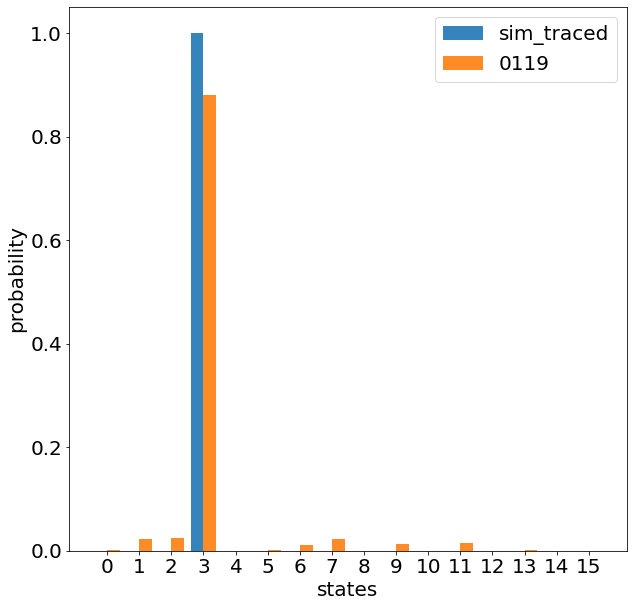

2024-01-19-161359_Line_002.txt
counts: [165, 37, 3, 0, 1651, 30, 26, 1, 11, 1, 0, 0, 54, 1, 20, 0]
counts_ibm_mapping_dic: {'0000': 165, '1000': 37, '0100': 3, '1100': 0, '0010': 1651, '1010': 30, '0110': 26, '1110': 1, '0001': 11, '1001': 1, '0101': 0, '1101': 0, '0011': 54, '1011': 1, '0111': 20, '1111': 0}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+21:RX+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



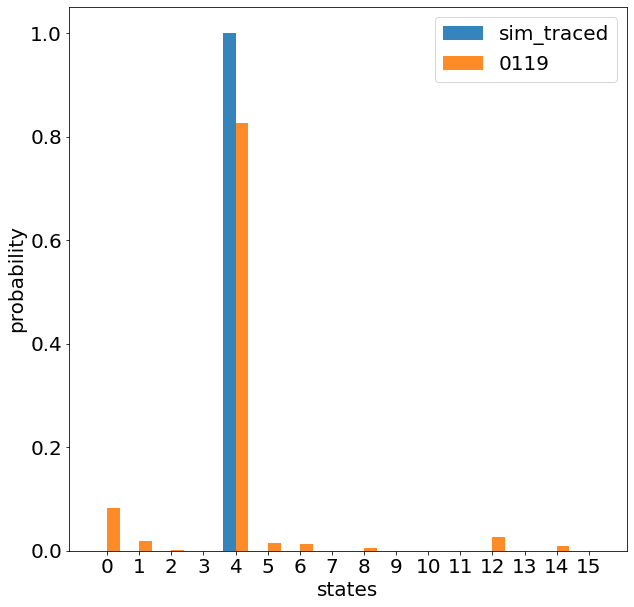

2024-01-19-161419_Line_003.txt
counts: [1, 3, 27, 71, 1, 31, 48, 1760, 0, 0, 1, 0, 0, 18, 2, 37]
counts_ibm_mapping_dic: {'0000': 1, '1000': 3, '0100': 27, '1100': 71, '0010': 1, '1010': 31, '0110': 48, '1110': 1760, '0001': 0, '1001': 0, '0101': 1, '1101': 0, '0011': 0, '1011': 18, '0111': 2, '1111': 37}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:RX+31:AZ2+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



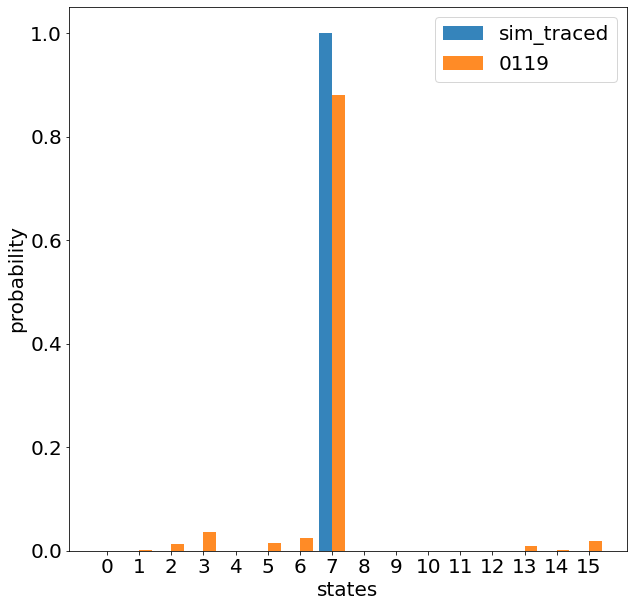

2024-01-19-161439_Line_004.txt
counts: [3, 84, 1, 43, 1, 4, 2, 2, 36, 1640, 2, 52, 56, 67, 5, 2]
counts_ibm_mapping_dic: {'0000': 3, '1000': 84, '0100': 1, '1100': 43, '0010': 1, '1010': 4, '0110': 2, '1110': 2, '0001': 36, '1001': 1640, '0101': 2, '1101': 52, '0011': 56, '1011': 67, '0111': 5, '1111': 2}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:RY+21:RX+31:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



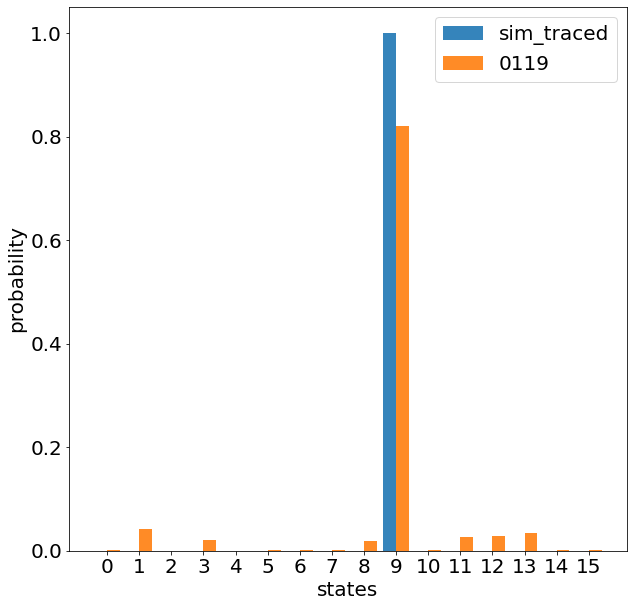

2024-01-19-161500_Line_005.txt
counts: [2, 43, 2, 54, 2, 2, 1, 1, 1, 41, 36, 1718, 1, 2, 10, 84]
counts_ibm_mapping_dic: {'0000': 2, '1000': 43, '0100': 2, '1100': 54, '0010': 2, '1010': 2, '0110': 1, '1110': 1, '0001': 1, '1001': 41, '0101': 36, '1101': 1718, '0011': 1, '1011': 2, '0111': 10, '1111': 84}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:RY+21:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



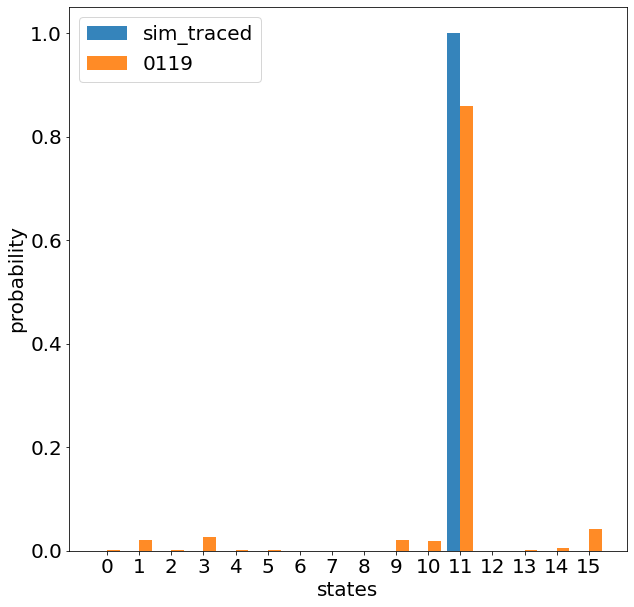

2024-01-19-161559_Line_006.txt
counts: [29, 77, 0, 0, 38, 1739, 2, 47, 0, 2, 0, 2, 2, 41, 1, 20]
counts_ibm_mapping_dic: {'0000': 29, '1000': 77, '0100': 0, '1100': 0, '0010': 38, '1010': 1739, '0110': 2, '1110': 47, '0001': 0, '1001': 2, '0101': 0, '1101': 2, '0011': 2, '1011': 41, '0111': 1, '1111': 20}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:RX+21:AZ3+1.0000:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



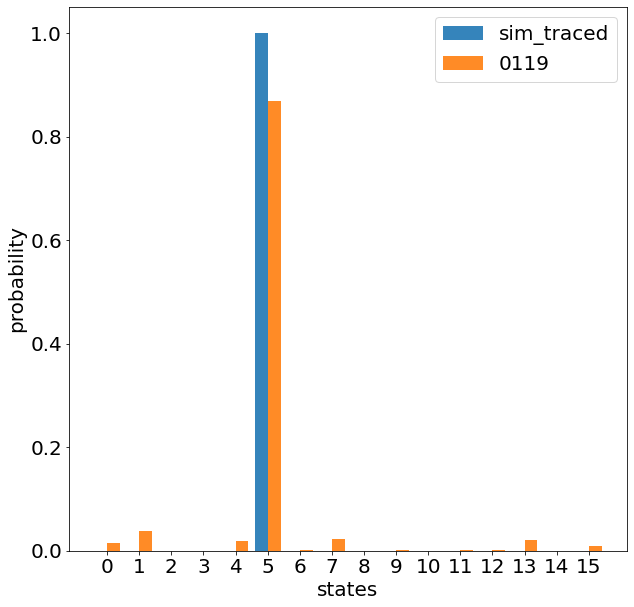

2024-01-19-180906_Line_007.txt
counts: [2, 1, 0, 3, 1, 35, 2, 46, 3, 2, 31, 77, 9, 51, 49, 1688]
counts_ibm_mapping_dic: {'0000': 2, '1000': 1, '0100': 0, '1100': 3, '0010': 1, '1010': 35, '0110': 2, '1110': 46, '0001': 3, '1001': 2, '0101': 31, '1101': 77, '0011': 9, '1011': 51, '0111': 49, '1111': 1688}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+21:RY+31:RX+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



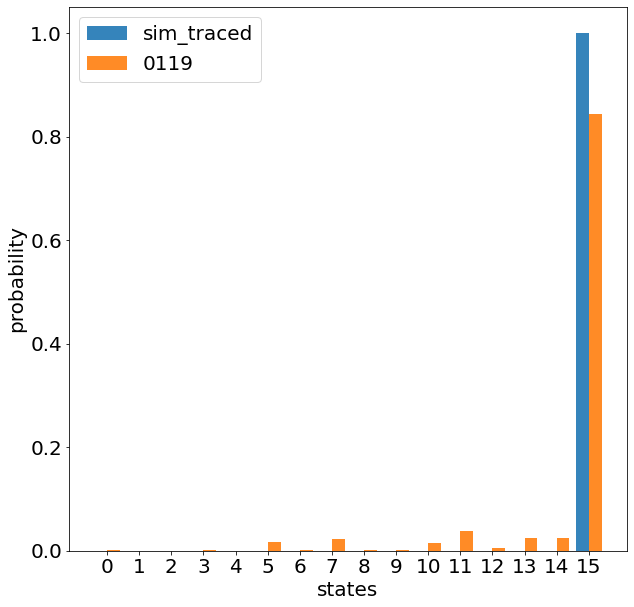

2024-01-19-180926_Line_008.txt
counts: [0, 28, 3, 69, 1, 1, 1, 4, 2, 57, 34, 1725, 0, 5, 15, 55]
counts_ibm_mapping_dic: {'0000': 0, '1000': 28, '0100': 3, '1100': 69, '0010': 1, '1010': 1, '0110': 1, '1110': 4, '0001': 2, '1001': 57, '0101': 34, '1101': 1725, '0011': 0, '1011': 5, '0111': 15, '1111': 55}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



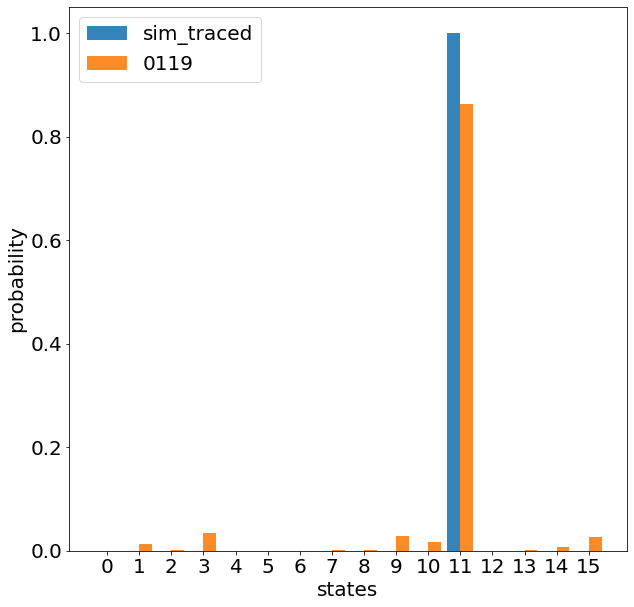

2024-01-19-180947_Line_009.txt
counts: [0, 26, 5, 80, 1, 0, 2, 1, 3, 59, 22, 1690, 1, 2, 31, 77]
counts_ibm_mapping_dic: {'0000': 0, '1000': 26, '0100': 5, '1100': 80, '0010': 1, '1010': 0, '0110': 2, '1110': 1, '0001': 3, '1001': 59, '0101': 22, '1101': 1690, '0011': 1, '1011': 2, '0111': 31, '1111': 77}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:RX+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



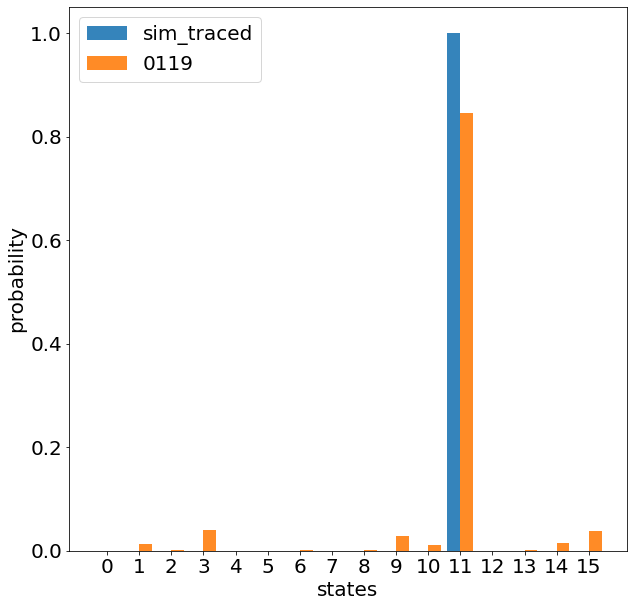

2024-01-19-181008_Line_010.txt
counts: [0, 1, 1, 1, 1, 23, 3, 57, 2, 5, 27, 54, 0, 53, 41, 1731]
counts_ibm_mapping_dic: {'0000': 0, '1000': 1, '0100': 1, '1100': 1, '0010': 1, '1010': 23, '0110': 3, '1110': 57, '0001': 2, '1001': 5, '0101': 27, '1101': 54, '0011': 0, '1011': 53, '0111': 41, '1111': 1731}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:RX+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



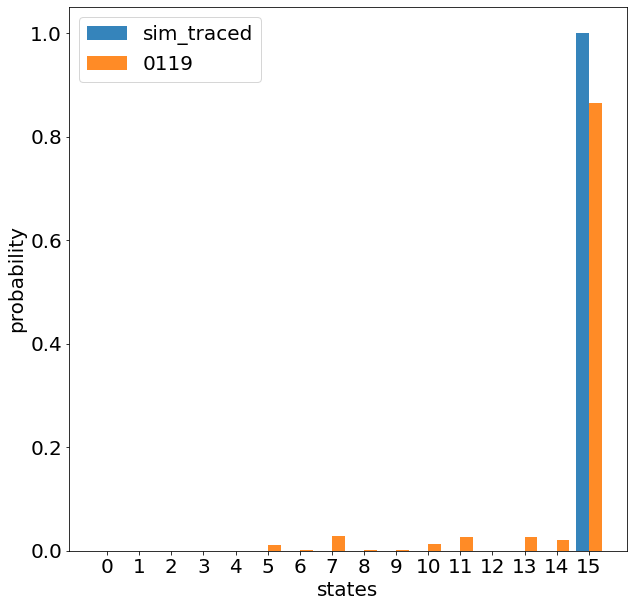

2024-01-19-163549_Line_011.txt
counts: [28, 1809, 0, 39, 22, 31, 0, 0, 4, 47, 0, 14, 1, 4, 0, 1]
counts_ibm_mapping_dic: {'0000': 28, '1000': 1809, '0100': 0, '1100': 39, '0010': 22, '1010': 31, '0110': 0, '1110': 0, '0001': 4, '1001': 47, '0101': 0, '1101': 14, '0011': 1, '1011': 4, '0111': 0, '1111': 1}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ3+1.0000:RY+31:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



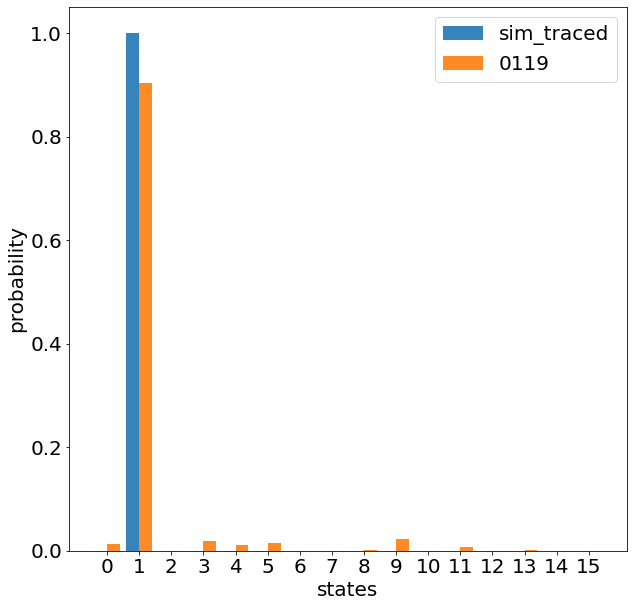

2024-01-19-163609_Line_012.txt
counts: [2, 0, 5, 1, 19, 1, 53, 1, 10, 0, 146, 24, 68, 7, 1622, 41]
counts_ibm_mapping_dic: {'0000': 2, '1000': 0, '0100': 5, '1100': 1, '0010': 19, '1010': 1, '0110': 53, '1110': 1, '0001': 10, '1001': 0, '0101': 146, '1101': 24, '0011': 68, '1011': 7, '0111': 1622, '1111': 41}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:RX+21:AZ3+1.0000:RX+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



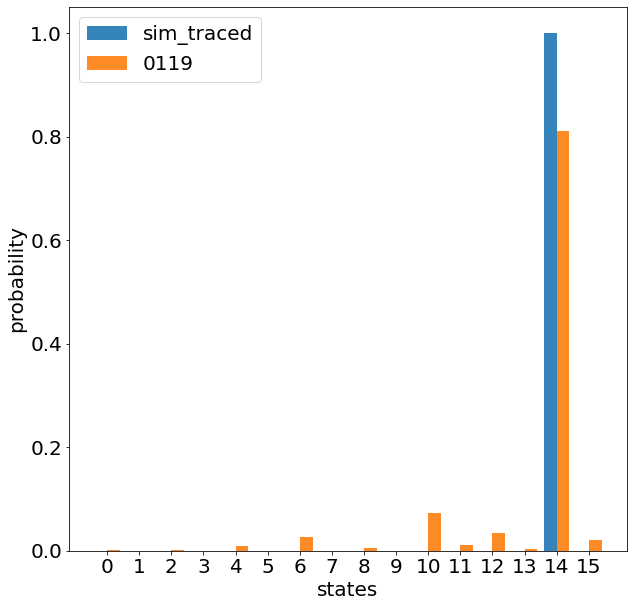

2024-01-19-163630_Line_013.txt
counts: [0, 5, 1, 3, 1, 32, 1, 53, 0, 0, 34, 61, 4, 40, 32, 1733]
counts_ibm_mapping_dic: {'0000': 0, '1000': 5, '0100': 1, '1100': 3, '0010': 1, '1010': 32, '0110': 1, '1110': 53, '0001': 0, '1001': 0, '0101': 34, '1101': 61, '0011': 4, '1011': 40, '0111': 32, '1111': 1733}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:AZ2+1.0000:AZ3+1.0000:RX+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



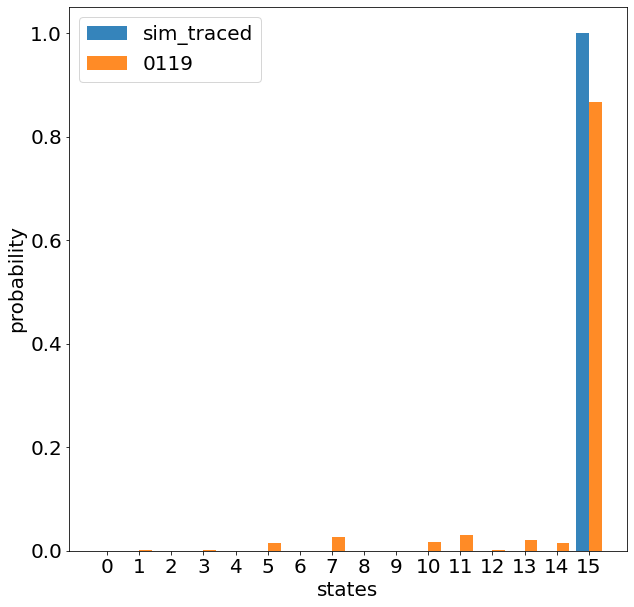

2024-01-19-163650_Line_014.txt
counts: [1720, 17, 17, 2, 131, 24, 4, 0, 55, 1, 9, 1, 13, 1, 5, 0]
counts_ibm_mapping_dic: {'0000': 1720, '1000': 17, '0100': 17, '1100': 2, '0010': 131, '1010': 24, '0110': 4, '1110': 0, '0001': 55, '1001': 1, '0101': 9, '1101': 1, '0011': 13, '1011': 1, '0111': 5, '1111': 0}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ2+1.0000:AZ3+1.0000:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



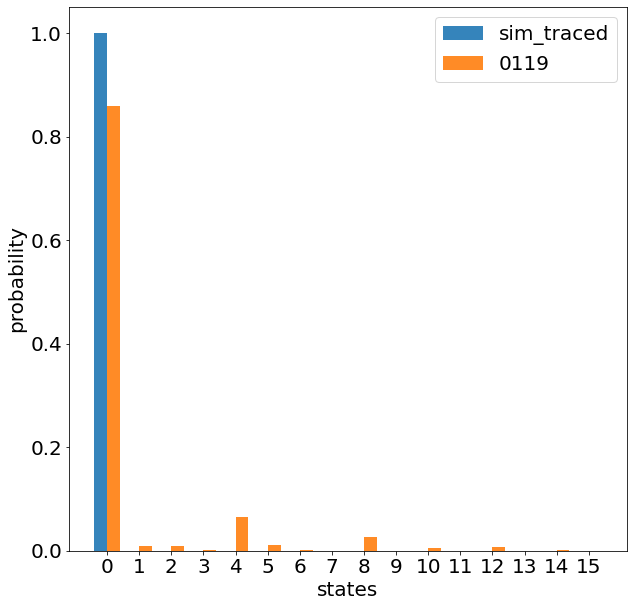

2024-01-19-163710_Line_015.txt
counts: [63, 3, 14, 1, 3, 0, 0, 0, 1695, 11, 41, 1, 132, 31, 2, 3]
counts_ibm_mapping_dic: {'0000': 63, '1000': 3, '0100': 14, '1100': 1, '0010': 3, '1010': 0, '0110': 0, '1110': 0, '0001': 1695, '1001': 11, '0101': 41, '1101': 1, '0011': 132, '1011': 31, '0111': 2, '1111': 3}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RX+21:AZ3+1.0000:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



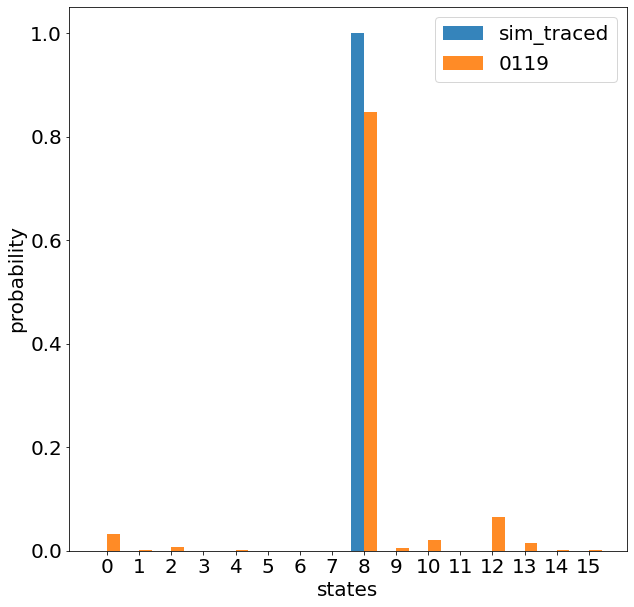

2024-01-19-175418_Line_016.txt
counts: [1663, 17, 22, 2, 162, 33, 7, 2, 45, 4, 21, 3, 11, 2, 3, 3]
counts_ibm_mapping_dic: {'0000': 1663, '1000': 17, '0100': 22, '1100': 2, '0010': 162, '1010': 33, '0110': 7, '1110': 2, '0001': 45, '1001': 4, '0101': 21, '1101': 3, '0011': 11, '1011': 2, '0111': 3, '1111': 3}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:RY+21:AZ3+1.0000:RX+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



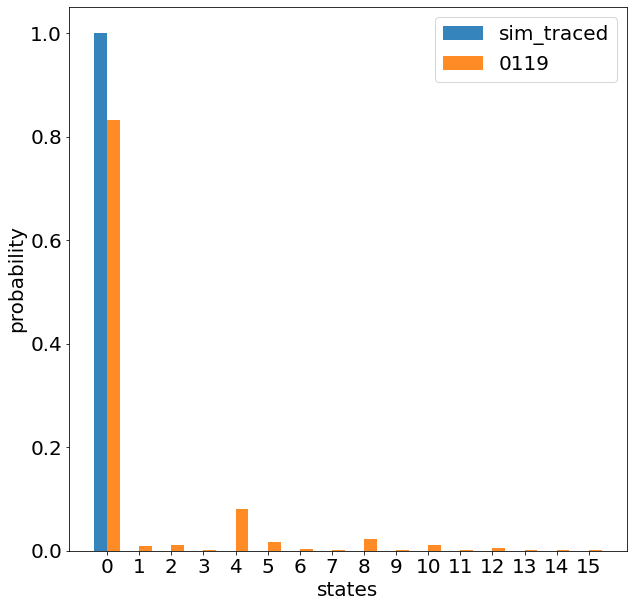

2024-01-19-175438_Line_017.txt
counts: [1, 39, 0, 62, 0, 1, 1, 4, 2, 43, 39, 1712, 0, 1, 31, 64]
counts_ibm_mapping_dic: {'0000': 1, '1000': 39, '0100': 0, '1100': 62, '0010': 0, '1010': 1, '0110': 1, '1110': 4, '0001': 2, '1001': 43, '0101': 39, '1101': 1712, '0011': 0, '1011': 1, '0111': 31, '1111': 64}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:RX+31:RX+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



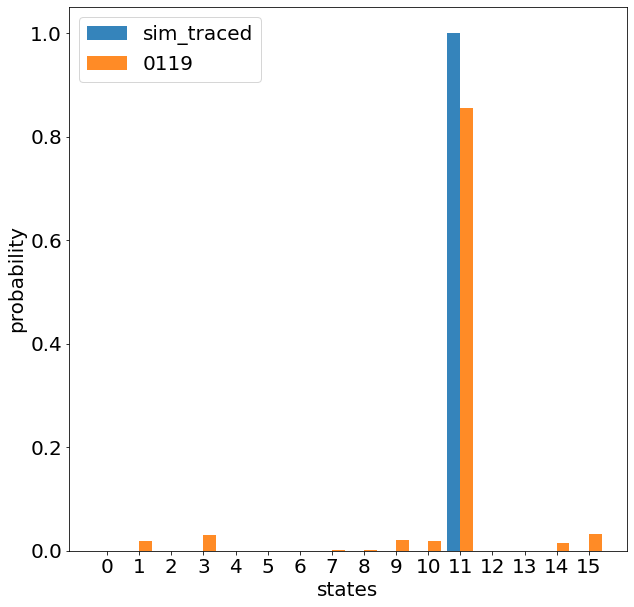

2024-01-19-175458_Line_018.txt
counts: [0, 2, 26, 74, 1, 43, 42, 1742, 1, 1, 0, 0, 2, 18, 3, 45]
counts_ibm_mapping_dic: {'0000': 0, '1000': 2, '0100': 26, '1100': 74, '0010': 1, '1010': 43, '0110': 42, '1110': 1742, '0001': 1, '1001': 1, '0101': 0, '1101': 0, '0011': 2, '1011': 18, '0111': 3, '1111': 45}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:RX+21:RX+31:RY+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



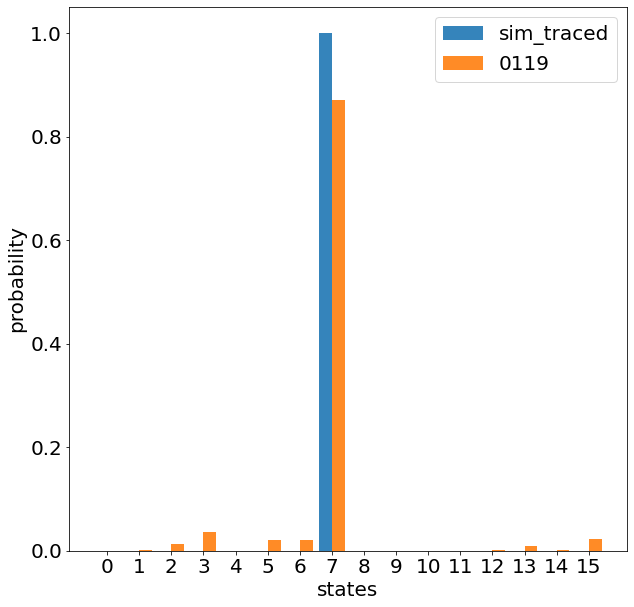

2024-01-19-175518_Line_019.txt
counts: [33, 1784, 2, 44, 18, 41, 0, 0, 5, 43, 4, 19, 1, 2, 1, 3]
counts_ibm_mapping_dic: {'0000': 33, '1000': 1784, '0100': 2, '1100': 44, '0010': 18, '1010': 41, '0110': 0, '1110': 0, '0001': 5, '1001': 43, '0101': 4, '1101': 19, '0011': 1, '1011': 2, '0111': 1, '1111': 3}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:RX+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



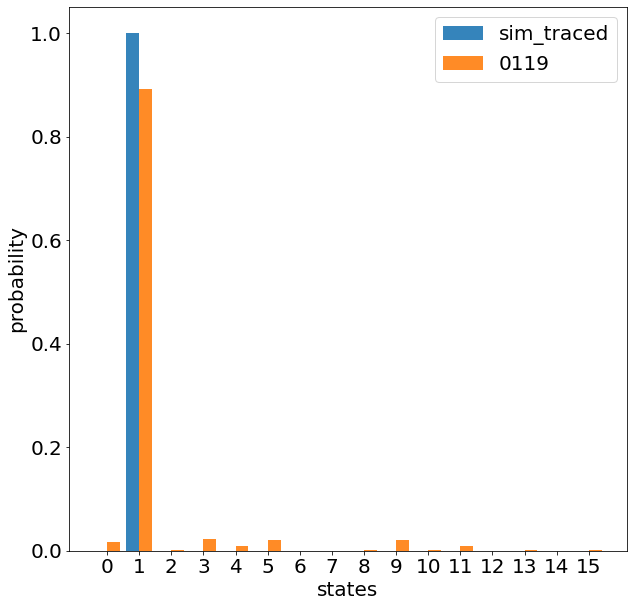

2024-01-19-175538_Line_020.txt
counts: [11, 1, 4, 0, 56, 1, 16, 0, 149, 26, 3, 0, 1661, 34, 33, 5]
counts_ibm_mapping_dic: {'0000': 11, '1000': 1, '0100': 4, '1100': 0, '0010': 56, '1010': 1, '0110': 16, '1110': 0, '0001': 149, '1001': 26, '0101': 3, '1101': 0, '0011': 1661, '1011': 34, '0111': 33, '1111': 5}
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:RY+31:RY+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



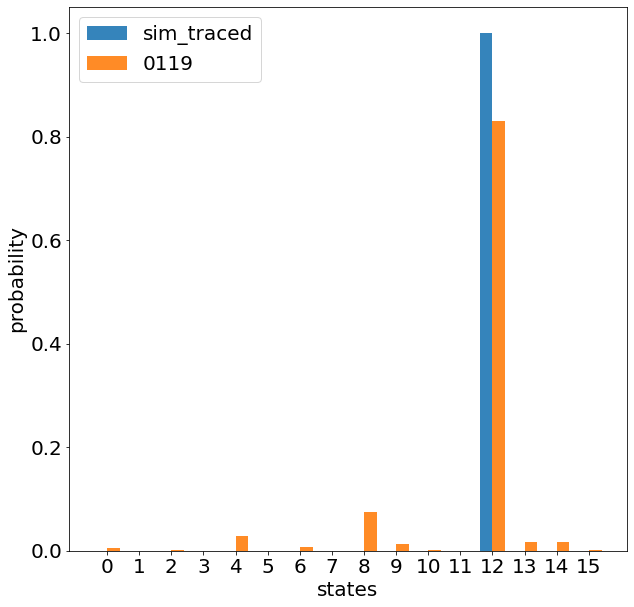

In [30]:
filenames_data=[]
counts_d2=[]
counts_d2_spam=[]
counts_d2_sim=[]
shots=2000
counts=[]
counts_spam=[]
counts_sim=[]

filenames_data=filenames_d2.copy()
# print (filenames_data)
paf_data=paf_data_d2
circuit=c_d2
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    print ("counts:", counts)
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    print ("counts_ibm_mapping_dic:",counts_ibm_mapping_dic)
    counts_d2.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     a_s=a
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d2_spam.append(counts_ibm_mapping_dic_spam)


    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
    counts_sim=[round(shots*x) for x in sim_traced.population]
    counts_ibm_mapping_sim, counts_ibm_mapping_dic_sim=map_statepop_2_ibm_mapping(counts_sim,nqubit)
    counts_d2_sim.append(counts_ibm_mapping_dic_sim)
    
    
#     Display_States_Population(states=[b,a,a_0703],label=["simulation","d=2 0711","0115 identity channel"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","0119"])
# #       


['2024-01-19-163938_Line_001.txt', '2024-01-19-165121_Line_002.txt', '2024-01-19-165141_Line_003.txt', '2024-01-19-165202_Line_004.txt', '2024-01-19-165222_Line_005.txt', '2024-01-19-165243_Line_006.txt', '2024-01-19-165341_Line_007.txt', '2024-01-19-165401_Line_008.txt', '2024-01-19-165421_Line_009.txt', '2024-01-19-165441_Line_010.txt', '2024-01-19-181156_Line_011.txt', '2024-01-19-181216_Line_012.txt', '2024-01-19-181237_Line_013.txt', '2024-01-19-181257_Line_014.txt', '2024-01-19-181317_Line_015.txt', '2024-01-19-181415_Line_016.txt', '2024-01-19-181435_Line_017.txt', '2024-01-19-181456_Line_018.txt', '2024-01-19-181516_Line_019.txt', '2024-01-19-181536_Line_020.txt']
2024-01-19-163938_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:AZ2+1.0000:AZ3+1.0000:RY+21:AZ2+1.0000:RY+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



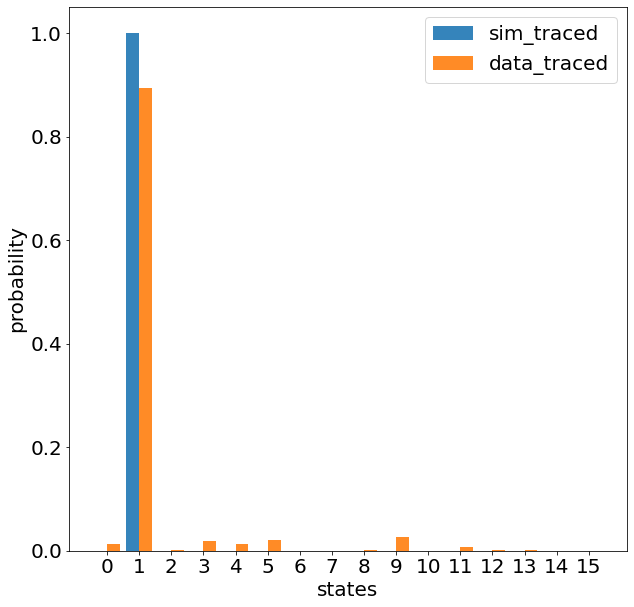

2024-01-19-165121_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:RX+31:AZ3+1.0000:RX+21:RY+31:AZ2+1.0000:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



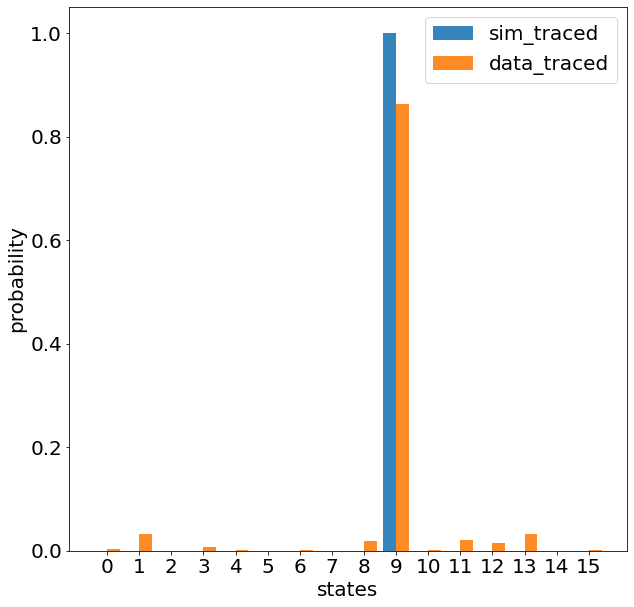

2024-01-19-165141_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:RX+21:RY+31:RY+21:RY+31:RX+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



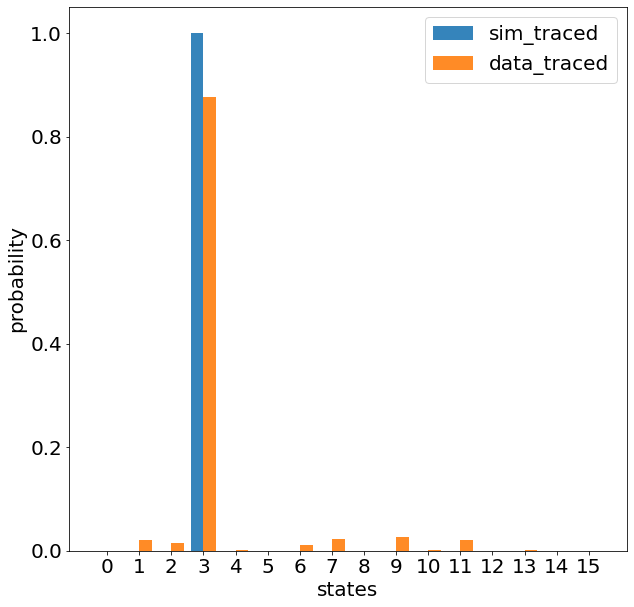

2024-01-19-165202_Line_004.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:AZ2+1.0000:RX+31:AZ3+1.0000:AZ2+1.0000:RY+31:AZ2+1.0000:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



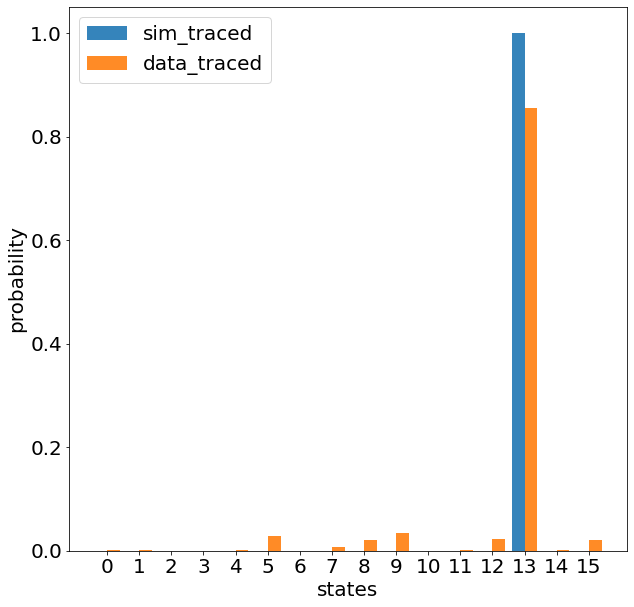

2024-01-19-165222_Line_005.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ2+1.0000:AZ2+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



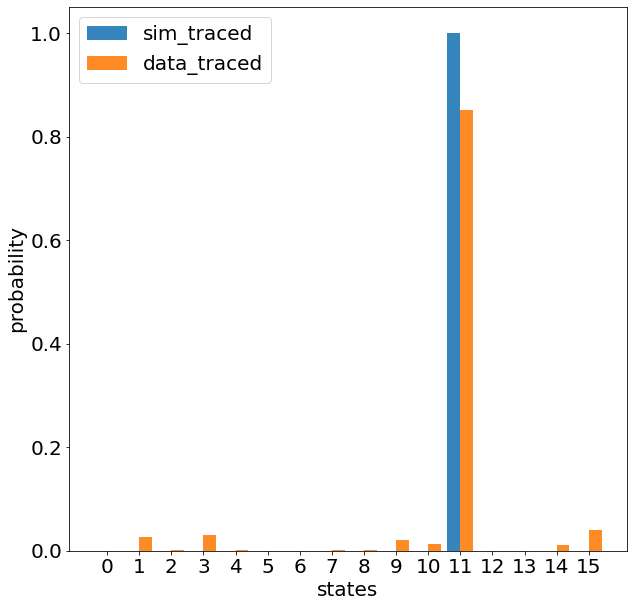

2024-01-19-165243_Line_006.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:RX+31:AZ2+1.0000:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



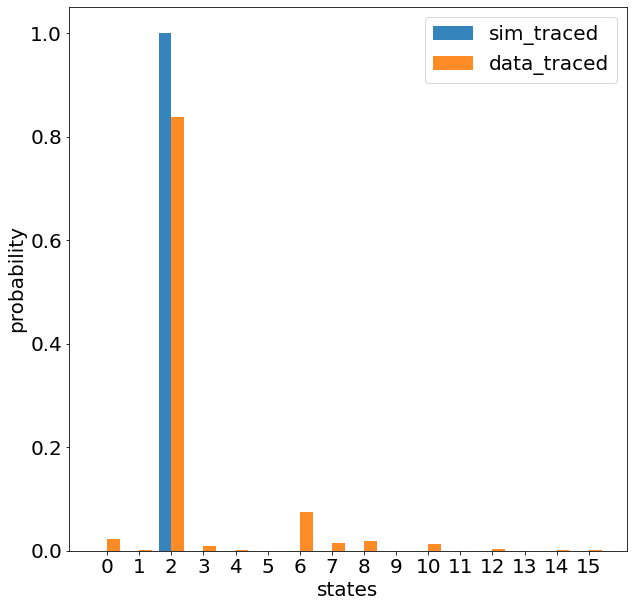

2024-01-19-165341_Line_007.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:AZ2+1.0000:RY+31:RX+21:RY+31:RY+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



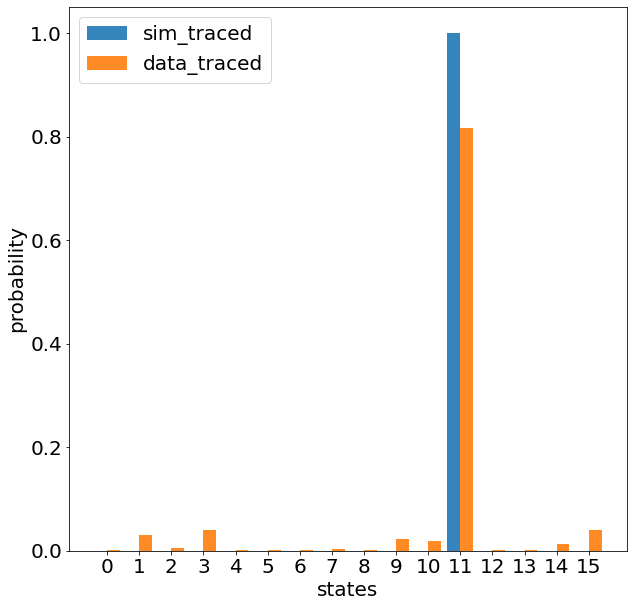

2024-01-19-165401_Line_008.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ3+1.0000:AZ2+1.0000:RX+31:RY+31:AZ2+1.0000:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



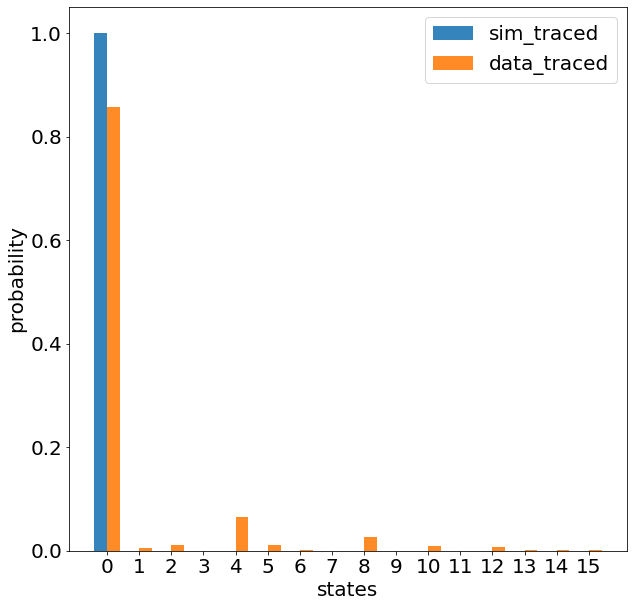

2024-01-19-165421_Line_009.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:RY+31:RY+21:RX+31:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



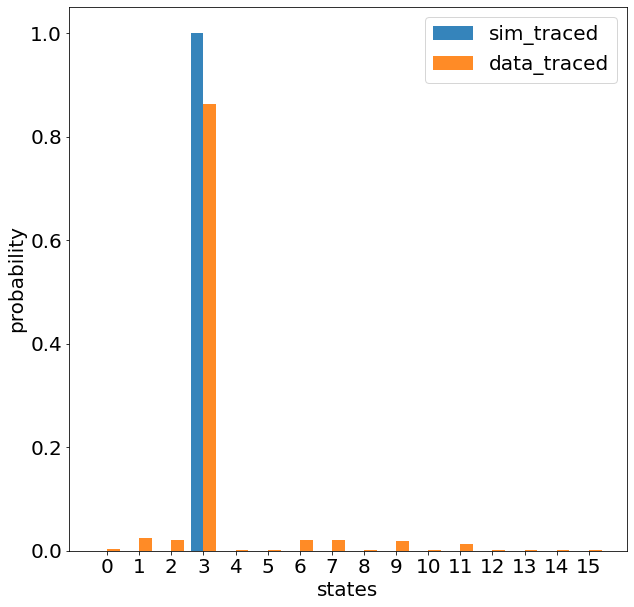

2024-01-19-165441_Line_010.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:RY+21:RX+31:AZ2+1.0000:RX+31:AZ2+1.0000:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



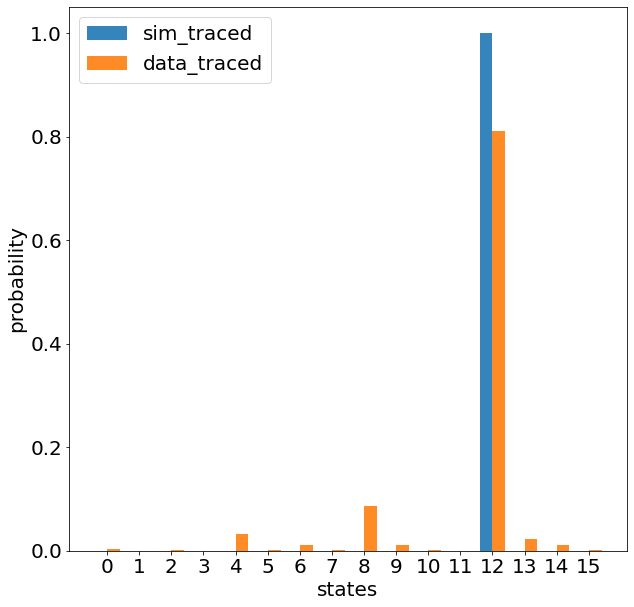

2024-01-19-181156_Line_011.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:RY+21:RY+31:RY+21:RX+31:RY+21:RY+31:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



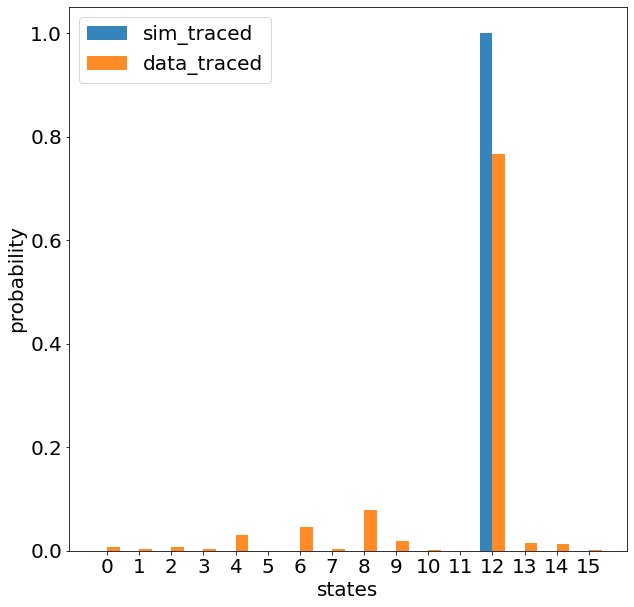

2024-01-19-181216_Line_012.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:AZ2+1.0000:RX+31:AZ2+1.0000:RY+31:RX+31:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



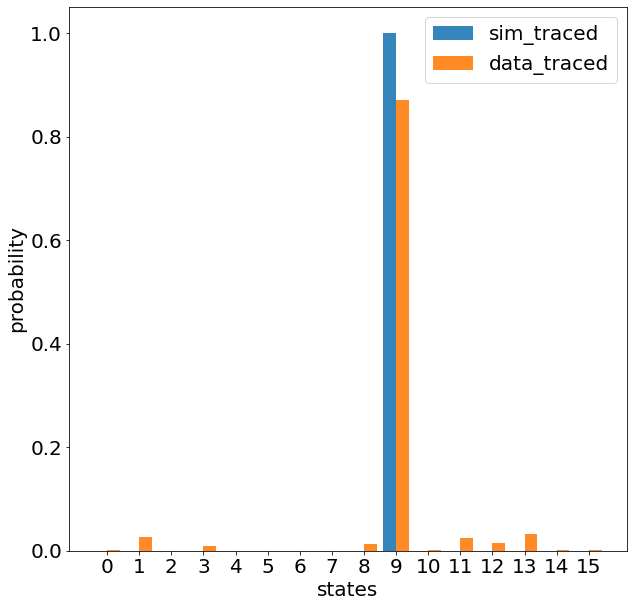

2024-01-19-181237_Line_013.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:RY+31:RY+21:AZ3+1.0000:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



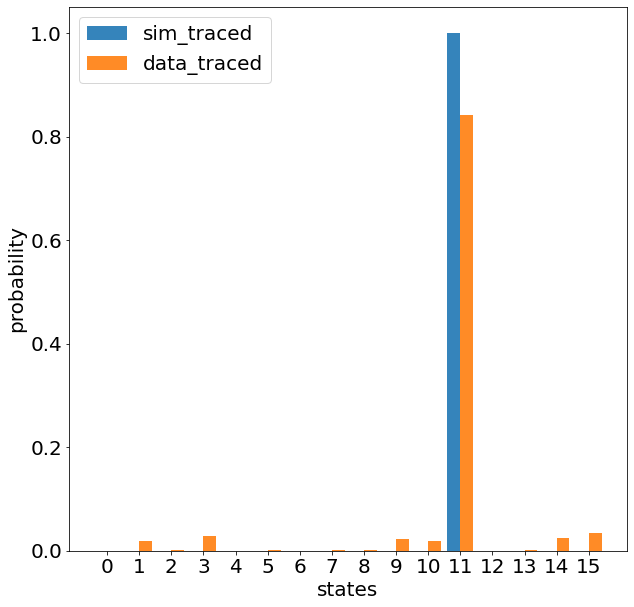

2024-01-19-181257_Line_014.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+21:AZ3+1.0000:RX+31:RY+21:AZ3+1.0000:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



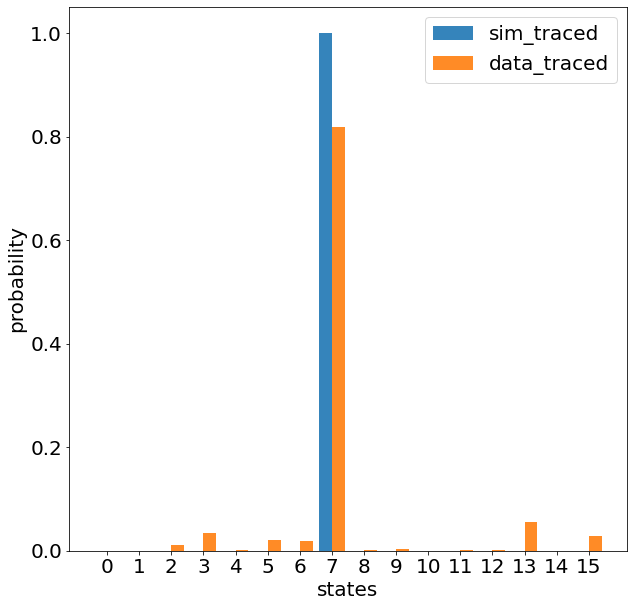

2024-01-19-181317_Line_015.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:RX+21:RY+31:RX+31:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



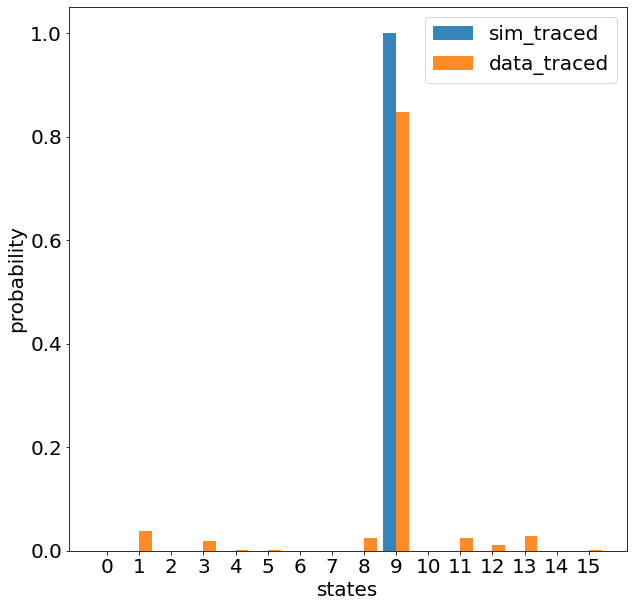

2024-01-19-181415_Line_016.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:AZ3+1.0000:RX+21:AZ3+1.0000:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



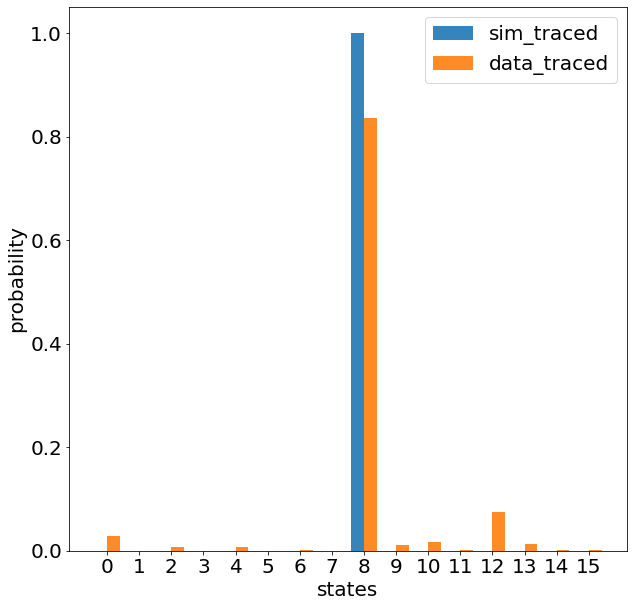

2024-01-19-181435_Line_017.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:RX+21:RY+31:RX+21:RY+31:RX+21:RX+31:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



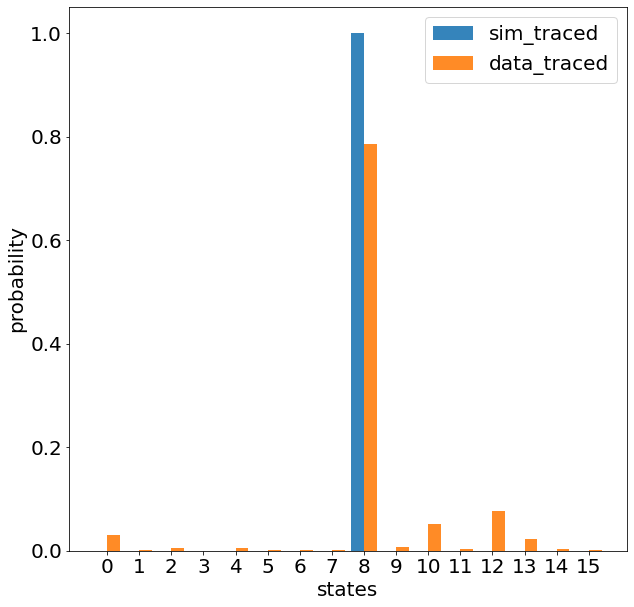

2024-01-19-181456_Line_018.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:RY+21:RY+31:RY+21:RY+31:RX+31:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



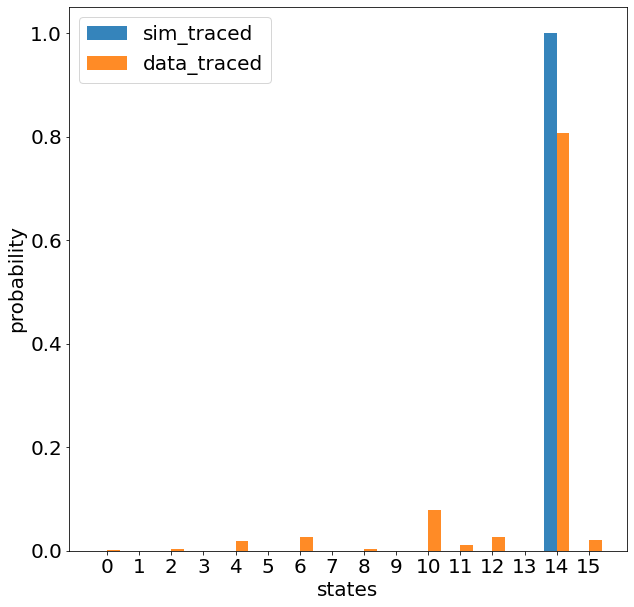

2024-01-19-181516_Line_019.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:RX+21:RX+31:AZ2+1.0000:RY+31:AZ3+1.0000:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



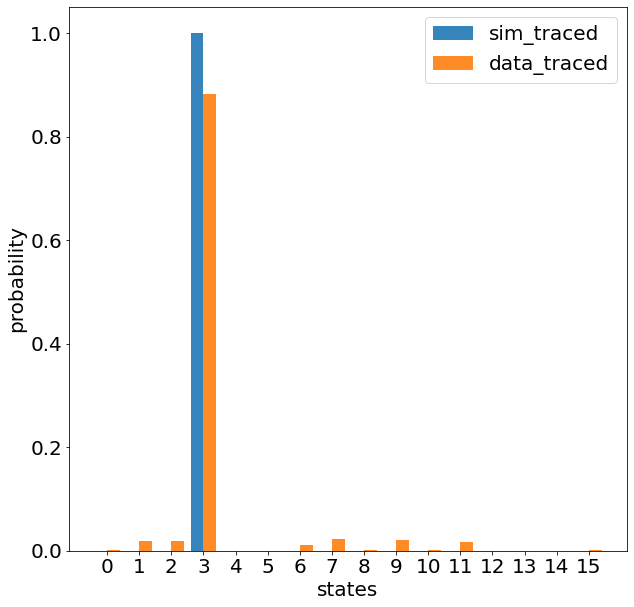

2024-01-19-181536_Line_020.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:RX+21:AZ2+1.0000:RY+31:RY+21:RX+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



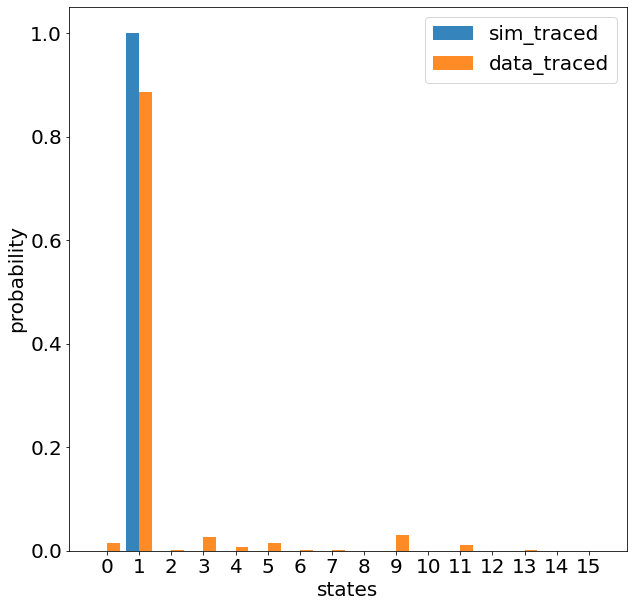

In [31]:
filenames_data=[]
counts_d4=[]
counts_d4_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d4.copy()
print (filenames_data)
paf_data=paf_data_d4
circuit=c_d4
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d4.append(counts_ibm_mapping_dic)
    
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d4_spam.append(counts_ibm_mapping_dic_spam)
    
#     a_0703.Import(paf_data_d4_0703+filenames_d4_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])

    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=4","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","data_traced"])
# #         

['2024-01-19-165707_Line_001.txt', '2024-01-19-165728_Line_002.txt', '2024-01-19-165749_Line_003.txt', '2024-01-19-165810_Line_004.txt', '2024-01-19-165831_Line_005.txt', '2024-01-19-165931_Line_006.txt', '2024-01-19-165951_Line_007.txt', '2024-01-19-170013_Line_008.txt', '2024-01-19-170034_Line_009.txt', '2024-01-19-170055_Line_010.txt', '2024-01-19-173908_Line_011.txt', '2024-01-19-173928_Line_012.txt', '2024-01-19-173949_Line_013.txt', '2024-01-19-174009_Line_014.txt', '2024-01-19-174030_Line_015.txt', '2024-01-19-174129_Line_016.txt', '2024-01-19-174150_Line_017.txt', '2024-01-19-174211_Line_018.txt', '2024-01-19-174232_Line_019.txt', '2024-01-19-174253_Line_020.txt']
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:RY+31:RY+21:RX+31:AZ2+1.0000:AZ3+1.0000:RX+21:RX+31:RY+31:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



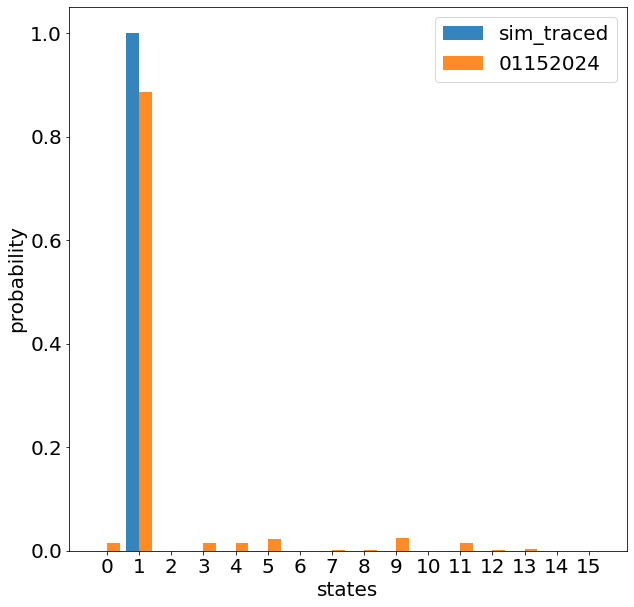

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ2+1.0000:AZ2+1.0000:RY+31:RX+21:AZ3+1.0000:RX+31:RY+31:AZ2+1.0000:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



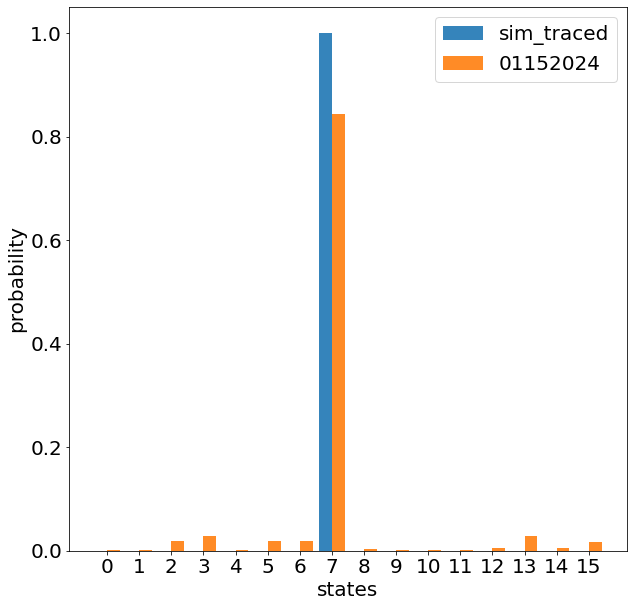

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:RY+21:RX+31:RX+21:RY+31:RY+21:RY+31:AZ2+1.0000:AZ2+1.0000:RX+31:RX+31:AZ3+1.0000:RY+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



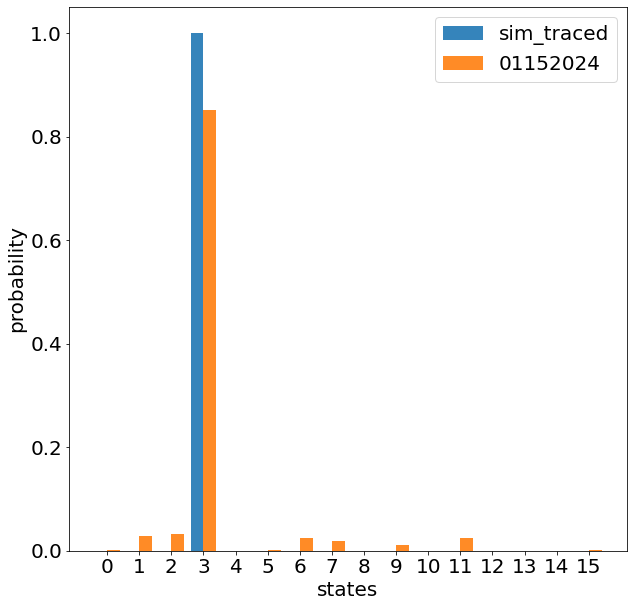

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:RY+21:AZ3+1.0000:RX+31:RY+21:RX+21:RX+31:RX+21:AZ3+1.0000:RY+21:AZ3+1.0000:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



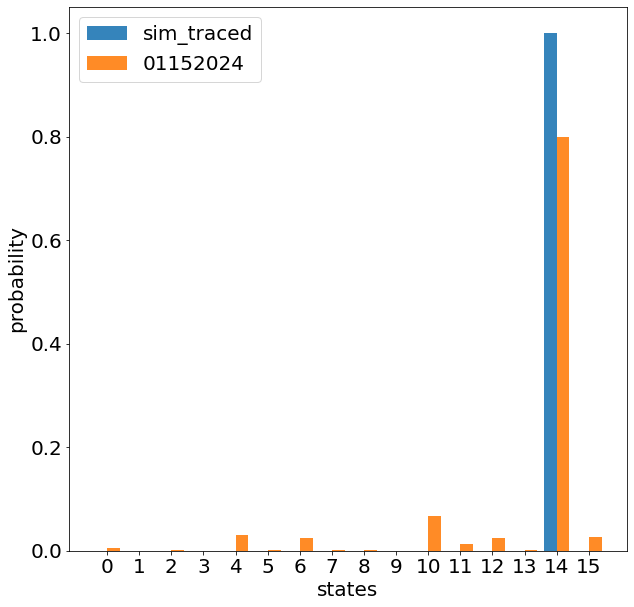

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:AZ2+1.0000:RX+31:RY+21:RX+31:RY+21:AZ3+1.0000:RY+21:RY+31:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



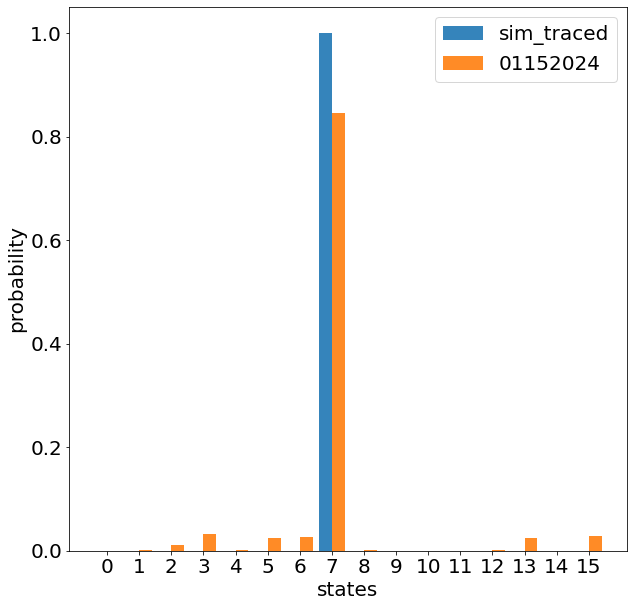

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:RY+21:AZ2+1.0000:RY+31:RX+21:RX+31:RY+21:RY+31:RY+31:RY+21:RX+31:RX+21:AZ2+1.0000:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



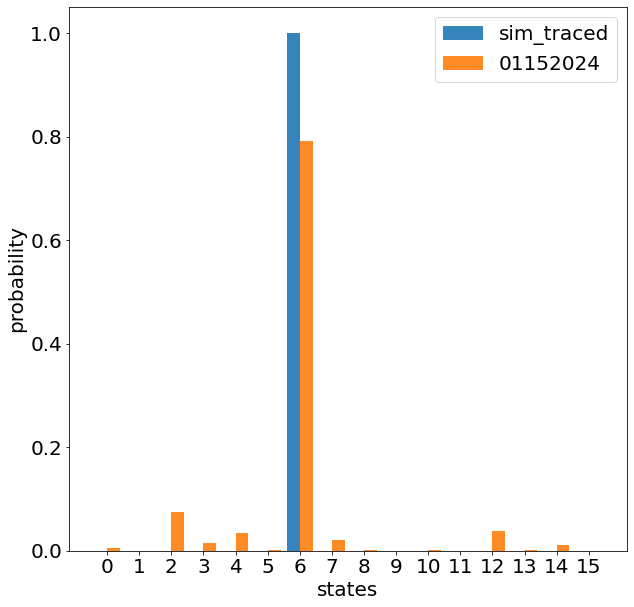

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ2+1.0000:RY+21:AZ3+1.0000:RX+21:AZ3+1.0000:AZ2+1.0000:AZ2+1.0000:RX+31:AZ2+1.0000:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



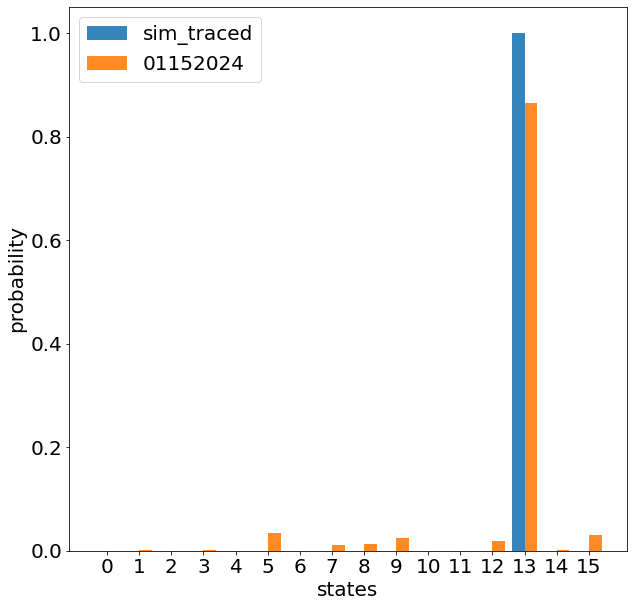

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+21:RY+21:RX+31:RY+21:RX+31:RX+21:RX+31:RX+21:AZ3+1.0000:RY+21:RY+31:RX+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



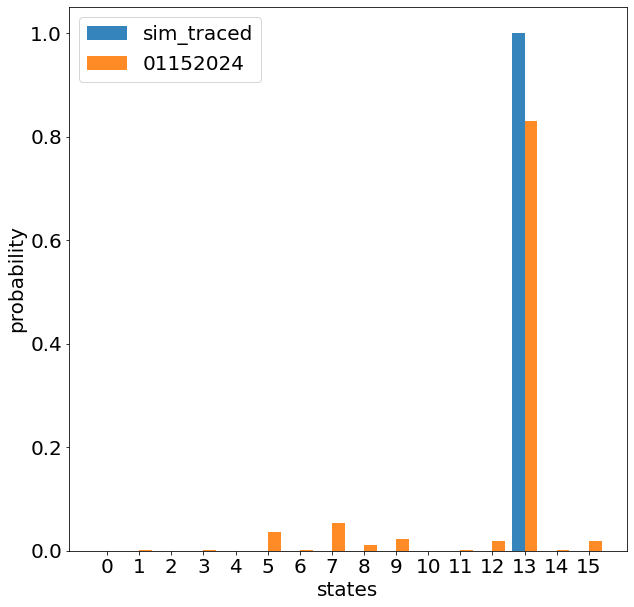

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+21:AZ2+1.0000:RX+31:RX+21:AZ2+1.0000:RX+31:RX+21:RX+31:RY+21:RX+31:RY+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



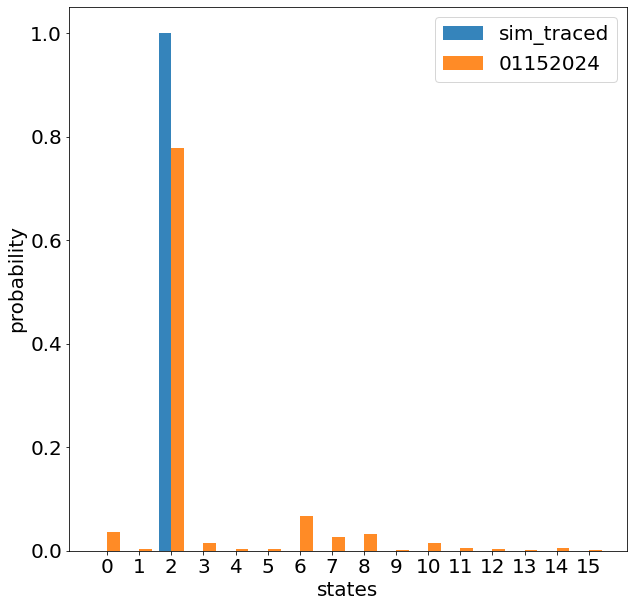

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:RY+21:RY+31:AZ3+1.0000:RY+21:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:RX+21:AZ3+1.0000:RY+21:AZ3+1.0000:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



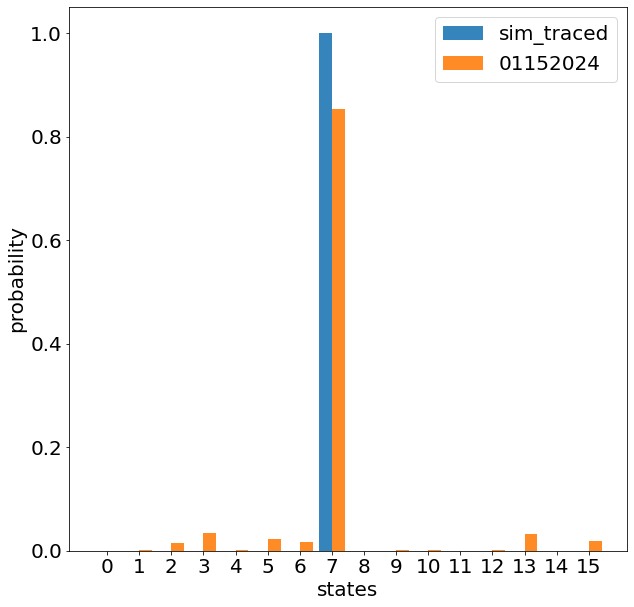

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:AZ2+1.0000:RX+31:RY+21:RY+31:RY+21:RY+31:AZ2+1.0000:AZ3+1.0000:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



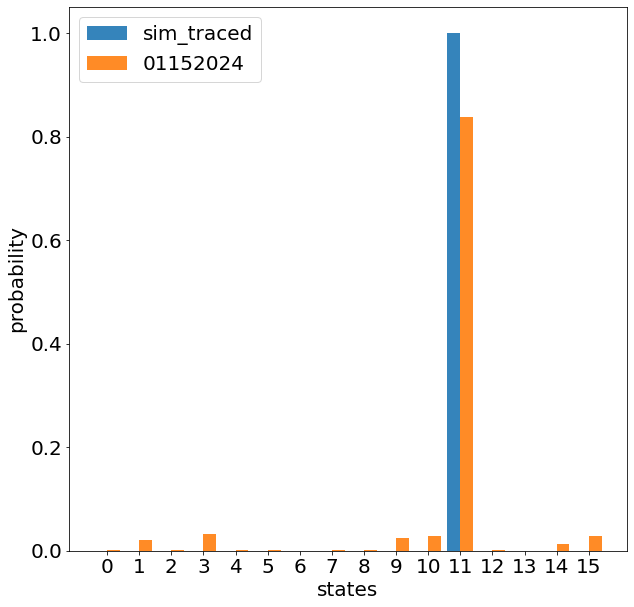

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:AZ2+1.0000:RX+31:AZ2+1.0000:AZ2+1.0000:RY+31:RY+21:RY+31:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



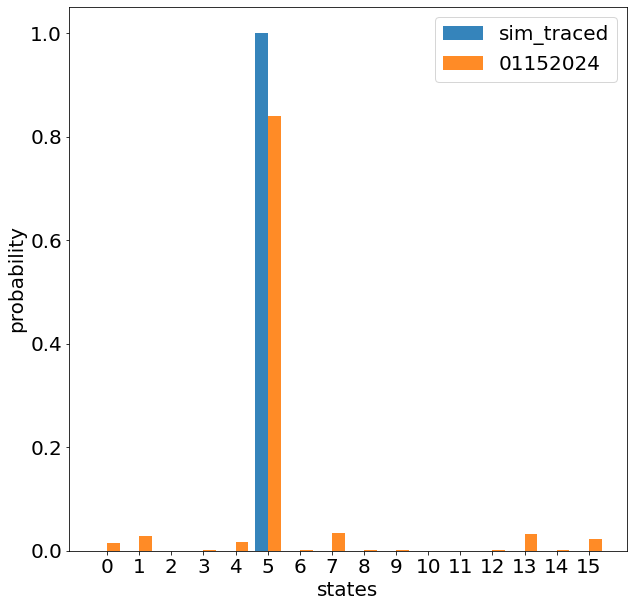

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+21:RY+31:RX+21:RY+31:RY+21:RX+31:RX+31:RY+21:AZ2+1.0000:RX+31:RY+31:AZ2+1.0000:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



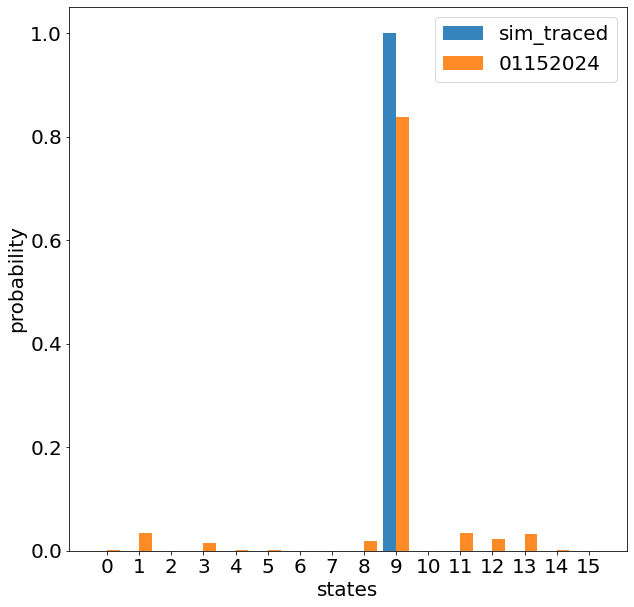

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:AZ3+1.0000:RY+21:AZ3+1.0000:RY+31:AZ3+1.0000:RX+21:RX+31:RX+21:RY+31:AZ2+1.0000:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



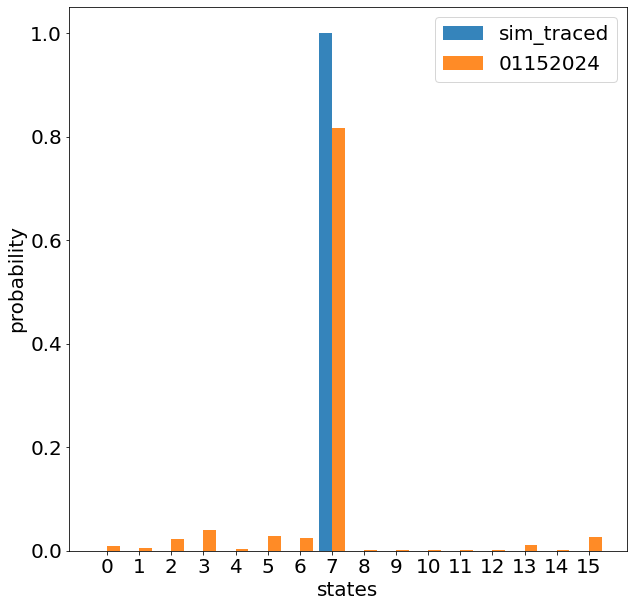

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:RY+21:RX+31:AZ2+1.0000:AZ2+1.0000:AZ2+1.0000:RY+31:RY+21:RY+31:RX+21:AZ3+1.0000:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



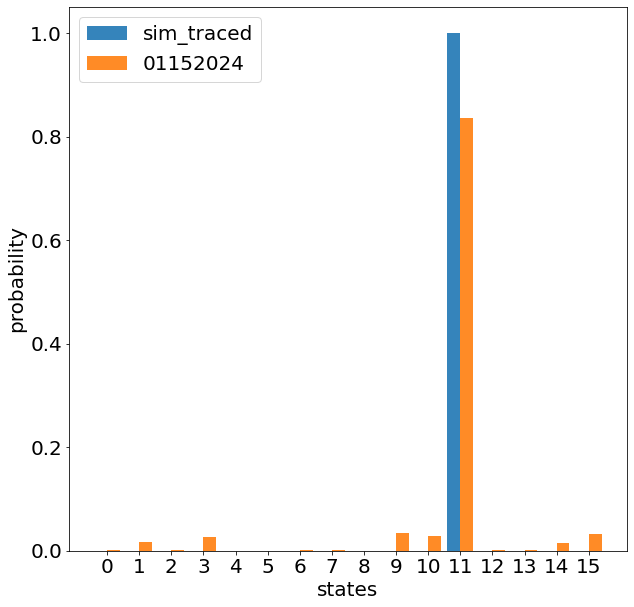

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:RY+21:AZ3+1.0000:AZ2+1.0000:RX+31:AZ2+1.0000:AZ3+1.0000:RX+21:RY+31:RX+31:RY+21:RX+31:RY+21:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



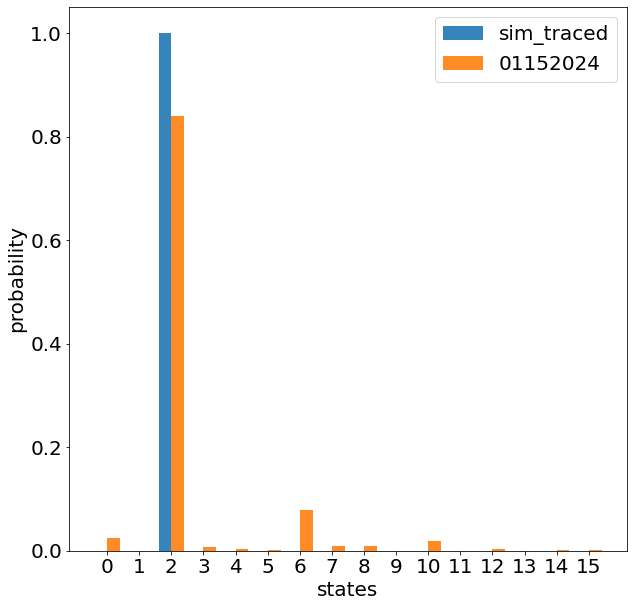

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:RX+21:RX+21:AZ3+1.0000:AZ2+1.0000:RX+21:RY+31:RX+21:AZ3+1.0000:RY+21:AZ2+1.0000:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



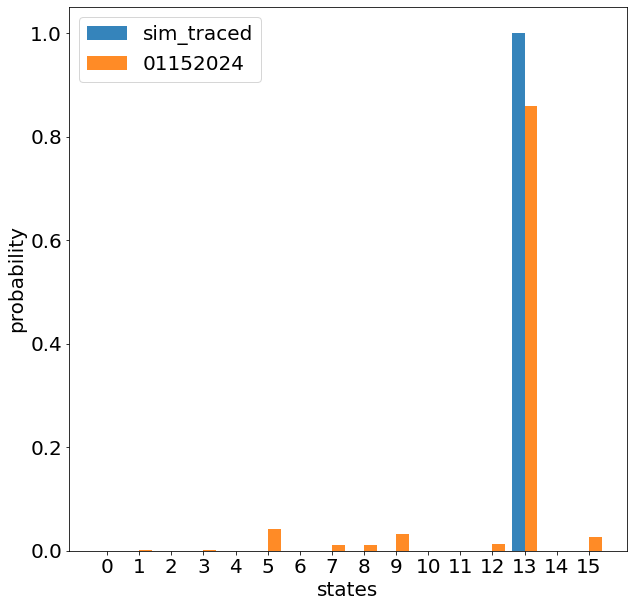

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:RX+21:RX+31:AZ3+1.0000:RY+21:AZ2+1.0000:RX+31:RY+31:RX+21:RY+21:RX+31:RX+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



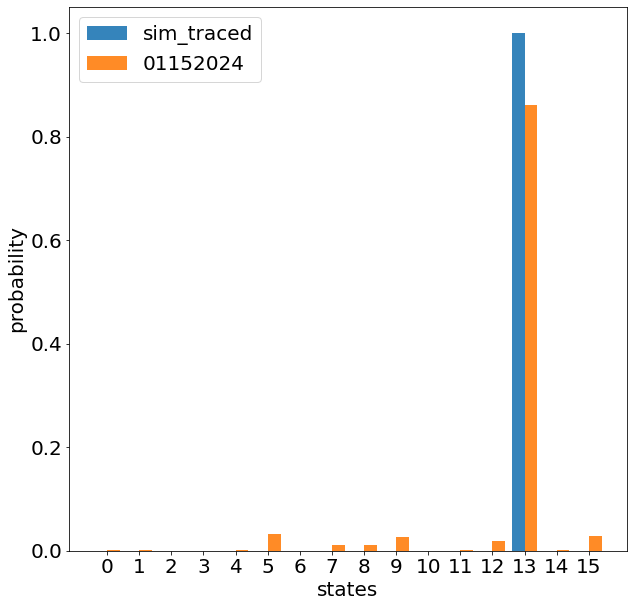

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:AZ2+1.0000:RY+21:AZ3+1.0000:RY+21:RX+31:AZ2+1.0000:RX+31:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



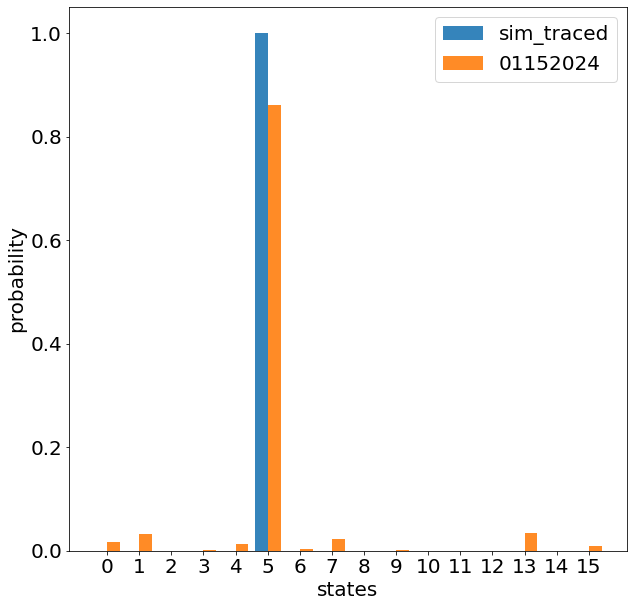

HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+21:RX+31:RX+21:RX+31:AZ2+1.0000:AZ3+1.0000:RY+21:RX+31:RX+21:RY+21:RX+21:RX+31:RX+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



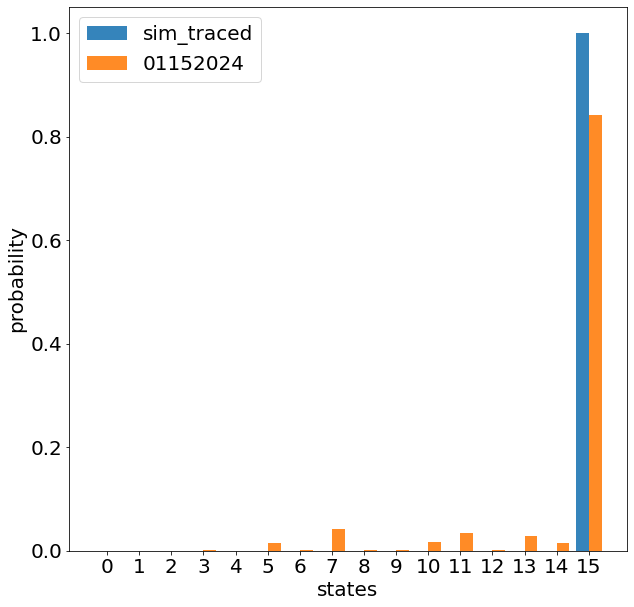

In [32]:
filenames_data=[]
counts_d8=[]
counts_d8_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d8.copy()
print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d8
circuit=c_d8
for i in range (len(filenames_data)):
#     print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d8.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
#     a_0703.Import(paf_data_d8_0703+filenames_d8_0703[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","01152024"])

['2024-01-19-170648_Line_001.txt', '2024-01-19-170710_Line_002.txt', '2024-01-19-170733_Line_003.txt', '2024-01-19-170755_Line_004.txt', '2024-01-19-170855_Line_005.txt', '2024-01-19-170918_Line_006.txt', '2024-01-19-170940_Line_007.txt', '2024-01-19-171002_Line_008.txt', '2024-01-19-171102_Line_009.txt', '2024-01-19-171124_Line_010.txt', '2024-01-19-182720_Line_011.txt', '2024-01-19-182742_Line_012.txt', '2024-01-19-182804_Line_013.txt', '2024-01-19-182825_Line_014.txt', '2024-01-19-182846_Line_015.txt', '2024-01-19-183634_Line_016.txt', '2024-01-19-183657_Line_017.txt', '2024-01-19-183718_Line_018.txt', '2024-01-19-183739_Line_019.txt', '2024-01-19-183801_Line_020.txt']
2024-01-19-170648_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RX+31:AZ2+1.0000:RX+31:AZ2+1.0000:RX+31:RX+21:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:RX+21:AZ2+1.0000:AZ3+1.0000:AZ2+1.0000:RX+31:AZ2+1.0000:RX+21:RY+31:AZ2+1.0000:RY+31:RY+21:RY+3

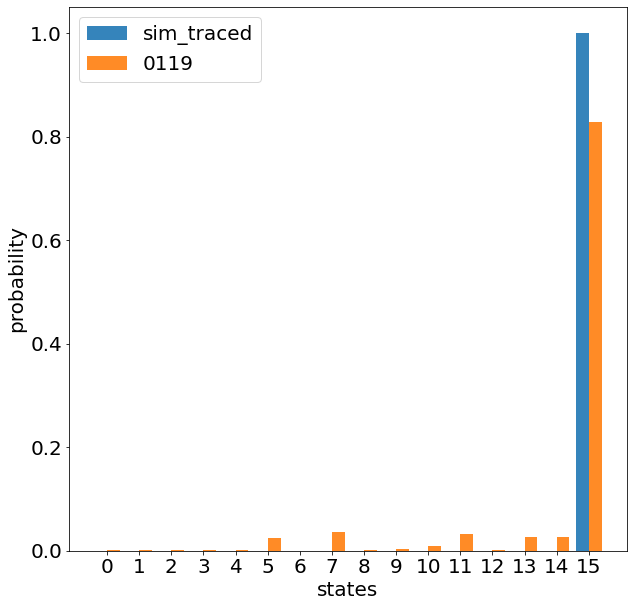

2024-01-19-170710_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:RX+21:AZ3+1.0000:RX+21:RX+31:RY+21:AZ3+1.0000:RY+21:AZ3+1.0000:AZ2+1.0000:RX+31:RY+21:RY+21:AZ2+1.0000:RY+31:RX+21:RX+31:AZ2+1.0000:RY+31:AZ2+1.0000:RY+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



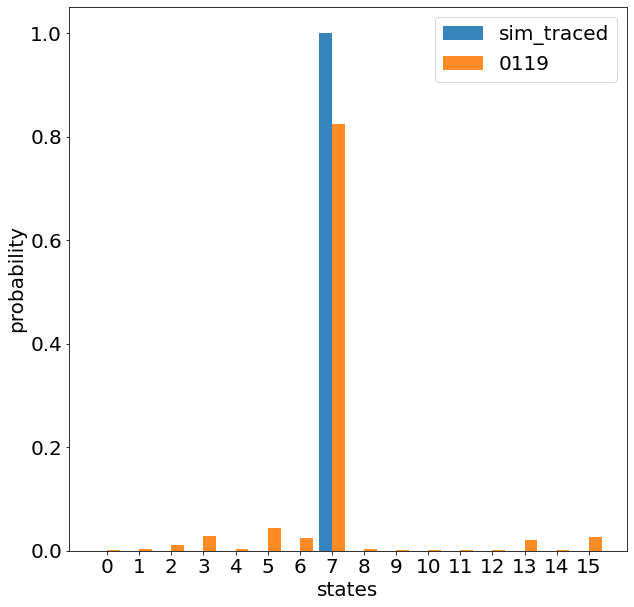

2024-01-19-170733_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:RY+21:RY+31:RX+21:AZ3+1.0000:RX+21:RY+31:AZ3+1.0000:RX+21:AZ3+1.0000:RY+21:AZ2+1.0000:RX+31:AZ3+1.0000:RX+21:RX+31:RY+21:RY+31:RX+21:AZ3+1.0000:AZ3+1.0000:RY+21:AZ2+1.0000:RY+31:AZ2+1.0000:RX+31:RX+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



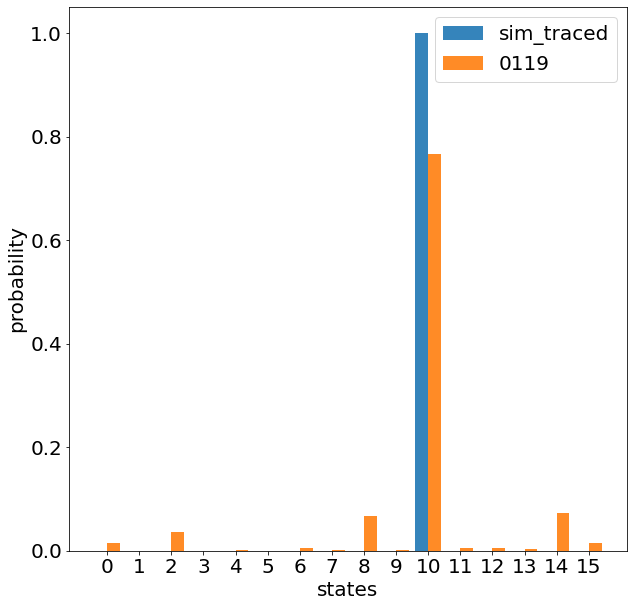

2024-01-19-170755_Line_004.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:RY+21:AZ3+1.0000:RY+21:RY+21:AZ3+1.0000:RX+21:AZ3+1.0000:AZ2+1.0000:RX+31:AZ2+1.0000:RY+21:RY+31:RY+21:RY+21:RY+31:AZ2+1.0000:RX+21:RX+31:RY+21:RY+31:RY+21:RX+31:RY+21:RY+31:RX+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



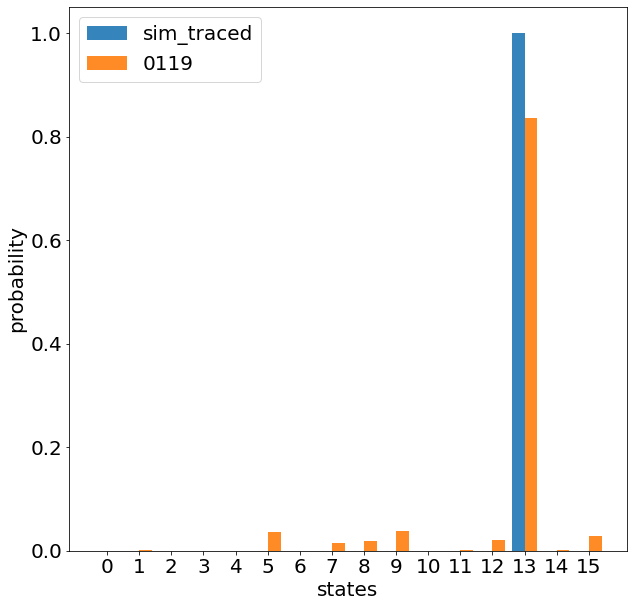

2024-01-19-170855_Line_005.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:RX+21:RX+31:RX+31:AZ2+1.0000:RX+21:RY+21:AZ3+1.0000:RY+21:AZ2+1.0000:RY+21:RX+21:RX+31:RY+31:RY+21:RY+21:AZ2+1.0000:RX+31:RX+21:RX+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



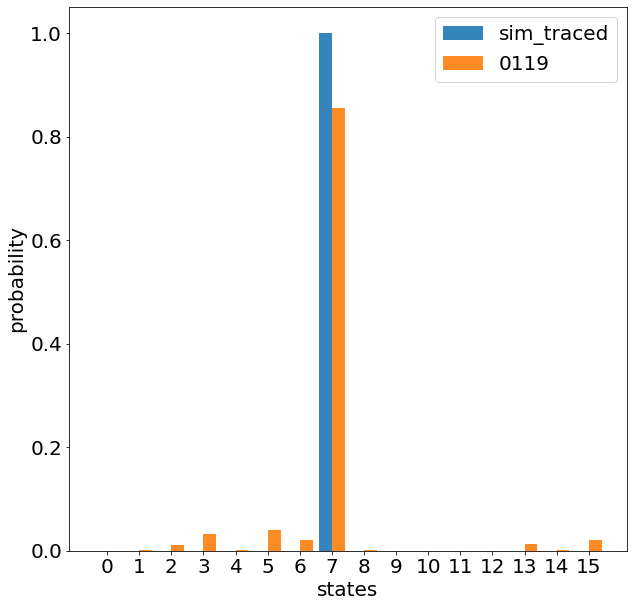

2024-01-19-170918_Line_006.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+21:RY+31:AZ2+1.0000:RY+31:AZ2+1.0000:AZ3+1.0000:RY+21:RX+31:RY+21:AZ3+1.0000:RX+21:RX+31:RY+31:AZ3+1.0000:AZ2+1.0000:RY+31:RY+21:RX+21:AZ3+1.0000:RX+21:RX+31:RY+21:RX+31:RY+31:RY+31:RX+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



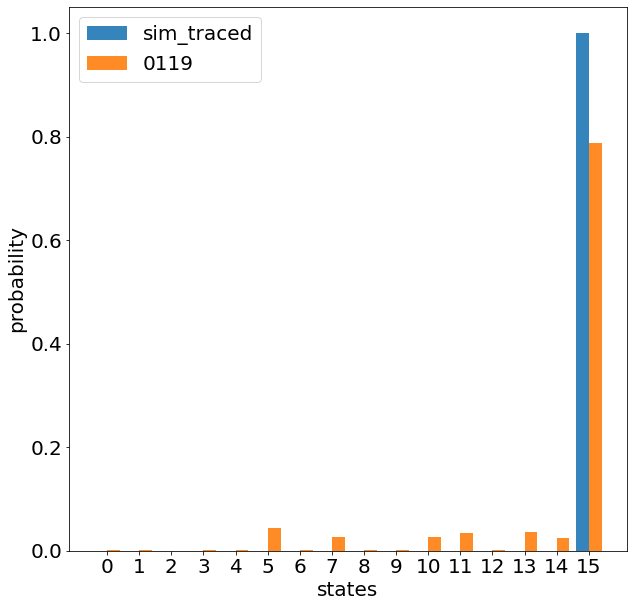

2024-01-19-170940_Line_007.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:RY+31:RY+21:RY+31:RY+21:RY+31:RX+21:AZ3+1.0000:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:AZ2+1.0000:RY+21:RY+31:AZ2+1.0000:RY+31:RY+21:RY+31:RX+21:RX+31:RX+21:RY+31:RX+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



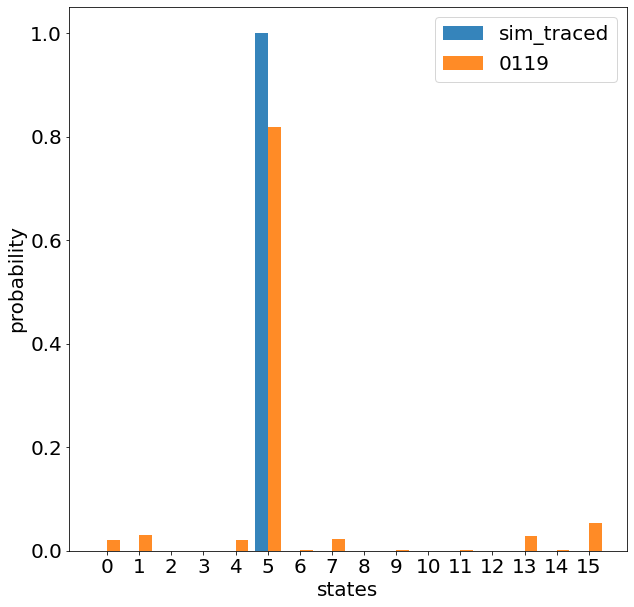

2024-01-19-171002_Line_008.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:RX+31:RY+21:AZ3+1.0000:RX+21:RY+31:AZ2+1.0000:RX+31:RX+21:RX+31:RX+21:AZ3+1.0000:RY+21:RX+31:RX+21:AZ2+1.0000:RX+31:RX+31:AZ3+1.0000:RY+21:RX+31:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



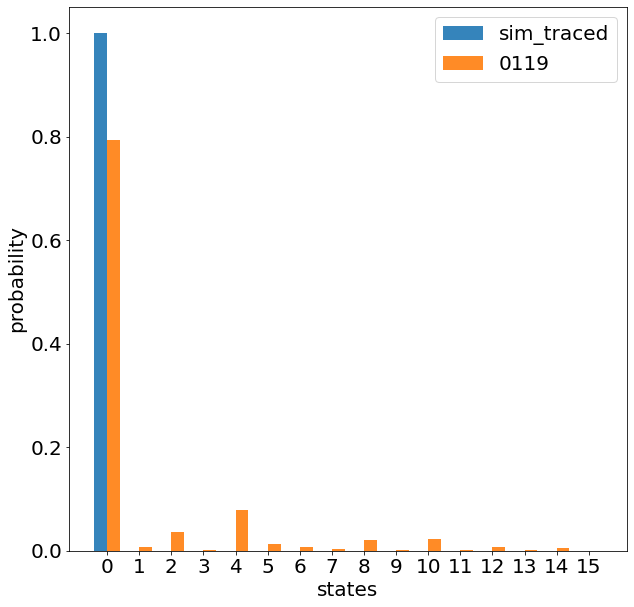

2024-01-19-171102_Line_009.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:RY+21:RY+31:AZ3+1.0000:AZ2+1.0000:RX+31:RX+21:RX+31:RY+21:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:RX+21:RY+31:AZ3+1.0000:RX+21:RX+31:RX+21:RY+21:AZ2+1.0000:RY+21:RY+31:RX+31:RX+21:RY+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



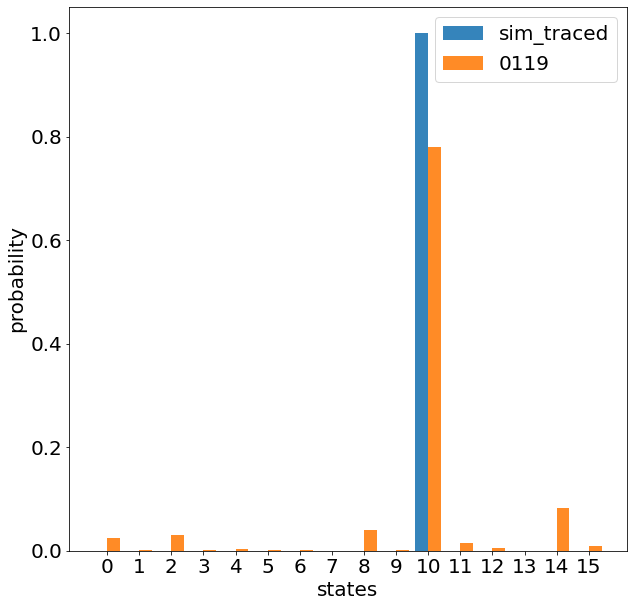

2024-01-19-171124_Line_010.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ3+1.0000:RY+21:RY+31:AZ2+1.0000:RY+31:RX+21:RX+31:AZ2+1.0000:RY+31:RX+21:AZ3+1.0000:RY+21:RX+31:RY+21:RY+31:RY+21:AZ3+1.0000:RX+31:RX+21:AZ3+1.0000:RX+21:RX+21:RX+31:RY+21:RX+31:AZ2+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



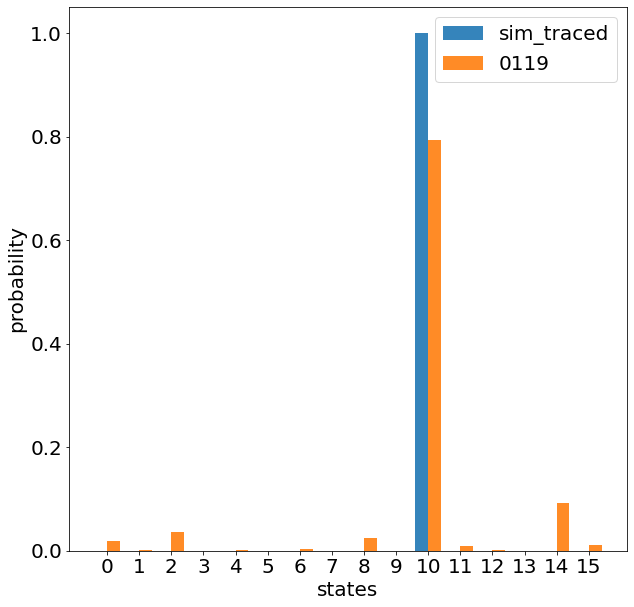

2024-01-19-182720_Line_011.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:RY+21:AZ3+1.0000:AZ2+1.0000:RY+31:RX+21:RY+31:RY+31:RX+21:RX+31:RY+21:AZ2+1.0000:RY+31:AZ2+1.0000:AZ3+1.0000:AZ2+1.0000:RY+31:RX+21:AZ3+1.0000:RX+21:RX+21:RY+31:RX+21:RX+31:RY+21:RX+31:RX+21:RX+31:RX+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



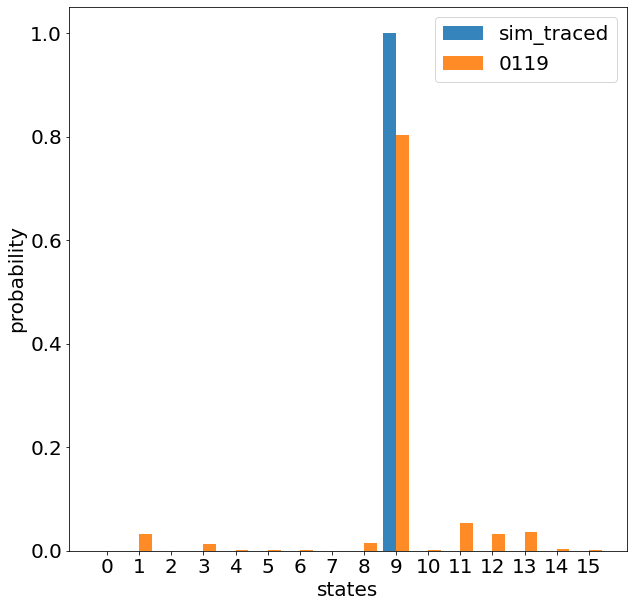

2024-01-19-182742_Line_012.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:AZ3+1.0000:AZ2+1.0000:RY+21:RX+31:AZ2+1.0000:RY+31:RX+21:AZ3+1.0000:RY+21:AZ3+1.0000:RX+21:AZ3+1.0000:RY+31:RX+31:RX+21:RX+31:RY+21:RY+31:RY+31:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:AZ2+1.0000:RY+31:RY+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



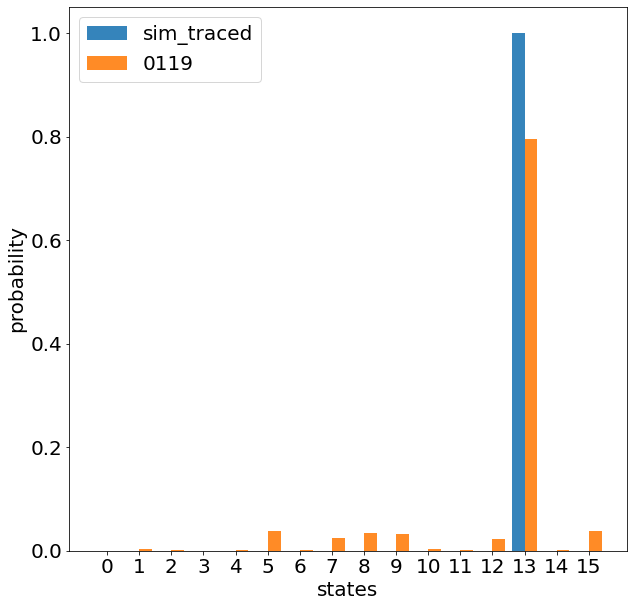

2024-01-19-182804_Line_013.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:RY+31:RX+21:RY+31:RY+21:RX+31:AZ2+1.0000:AZ2+1.0000:RY+31:AZ2+1.0000:AZ3+1.0000:RX+21:RY+31:RY+31:RX+21:RX+31:RX+21:RY+31:RX+21:RX+31:AZ2+1.0000:AZ2+1.0000:AZ3+1.0000:RY+21:RY+31:RX+21:AZ2+1.0000:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



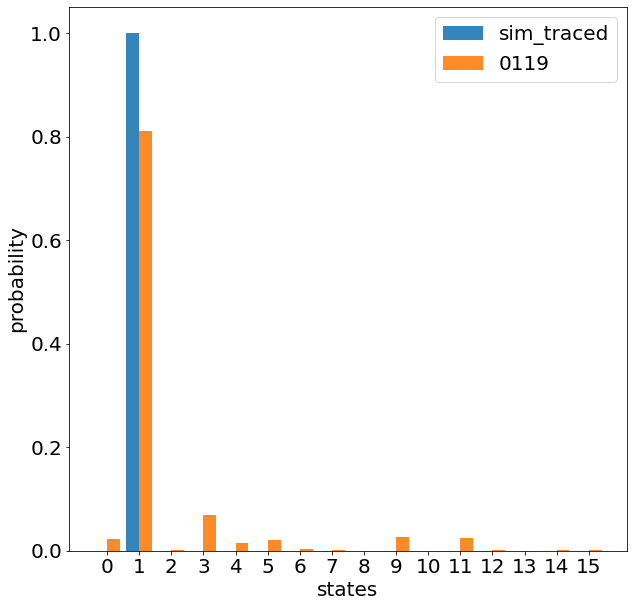

2024-01-19-182825_Line_014.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:RX+21:RY+31:RX+31:AZ2+1.0000:RY+21:RY+31:AZ3+1.0000:RX+21:RY+31:RY+21:RX+21:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:RX+21:RY+31:AZ2+1.0000:RY+31:RY+31:AZ2+1.0000:RX+31:AZ2+1.0000:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



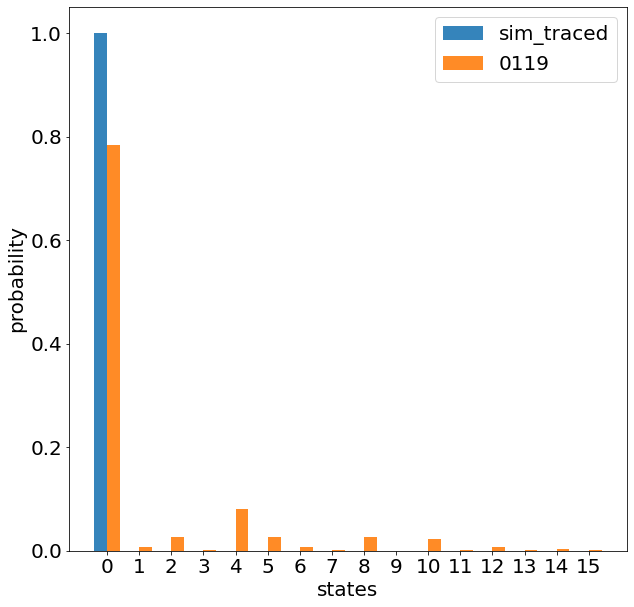

2024-01-19-182846_Line_015.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:AZ2+1.0000:RX+31:AZ2+1.0000:AZ2+1.0000:AZ2+1.0000:RX+31:AZ2+1.0000:RY+31:RX+21:RX+31:RY+21:AZ3+1.0000:AZ2+1.0000:RX+31:AZ2+1.0000:RX+31:AZ2+1.0000:AZ3+1.0000:RX+21:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



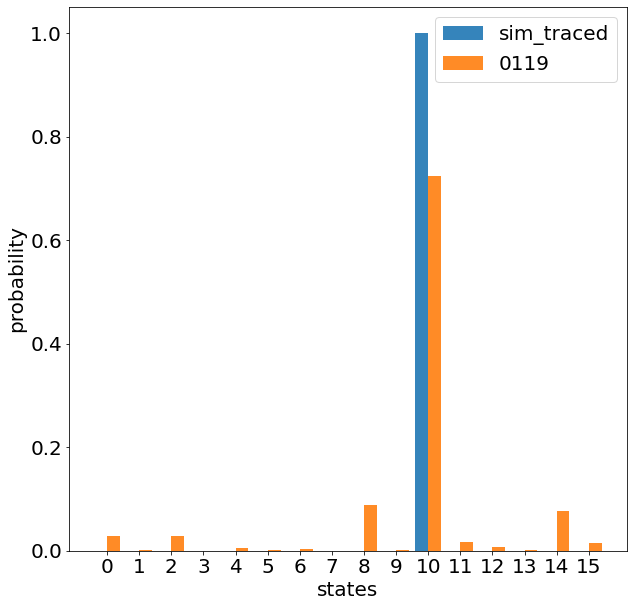

2024-01-19-183634_Line_016.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:RY+21:RX+31:RY+21:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:RX+21:AZ3+1.0000:RX+21:RX+31:AZ2+1.0000:AZ3+1.0000:RY+21:RX+21:AZ3+1.0000:RY+21:AZ3+1.0000:AZ2+1.0000:RY+31:RY+31:RX+21:RX+21:RX+31:RY+21:RY+31:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



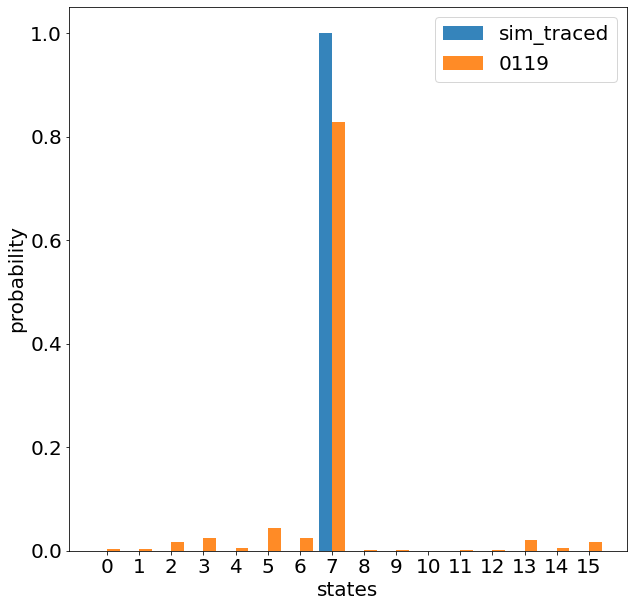

2024-01-19-183657_Line_017.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:RX+21:RY+31:AZ3+1.0000:RY+21:RY+21:AZ3+1.0000:AZ2+1.0000:RX+31:AZ2+1.0000:RX+31:RX+21:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:RY+21:RY+31:RX+31:RY+21:AZ3+1.0000:RX+21:RY+31:RY+21:AZ3+1.0000:RY+21:RX+31:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



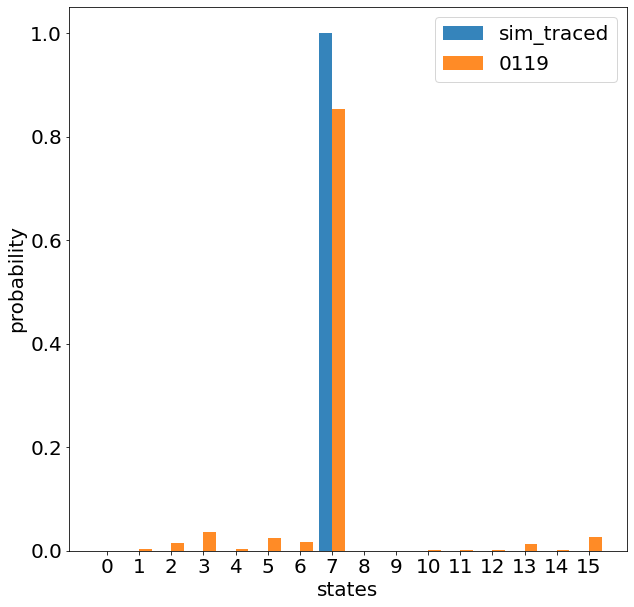

2024-01-19-183718_Line_018.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:AZ3+1.0000:AZ2+1.0000:AZ2+1.0000:RX+31:RY+31:RX+31:RY+21:AZ3+1.0000:RX+21:RY+31:AZ2+1.0000:RX+31:RX+21:RX+31:RX+21:RX+31:AZ2+1.0000:RX+31:AZ2+1.0000:AZ2+1.0000:RX+31:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



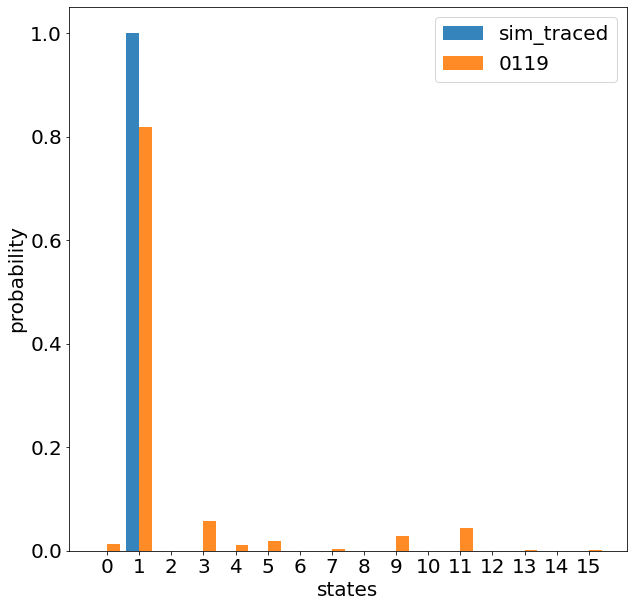

2024-01-19-183739_Line_019.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+21:AZ3+1.0000:AZ2+1.0000:RX+31:RY+21:AZ2+1.0000:RX+21:AZ3+1.0000:RY+31:RX+21:RX+31:RX+21:RY+31:RY+31:RX+21:AZ3+1.0000:AZ2+1.0000:RY+31:RY+31:RX+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



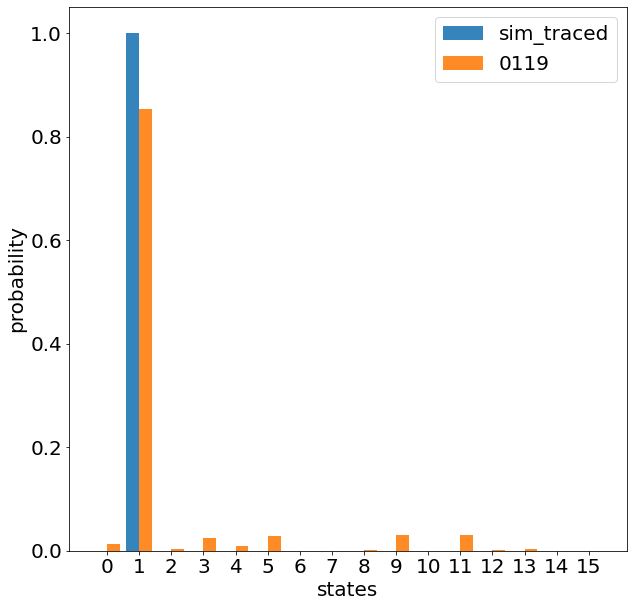

2024-01-19-183801_Line_020.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:RX+21:RX+31:RY+21:RY+31:AZ2+1.0000:RX+31:RX+21:RY+21:RY+31:RX+31:RY+21:RY+21:AZ2+1.0000:RX+31:RX+31:RY+21:AZ3+1.0000:AZ2+1.0000:RY+31:RY+21:RY+31:AZ2+1.0000:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



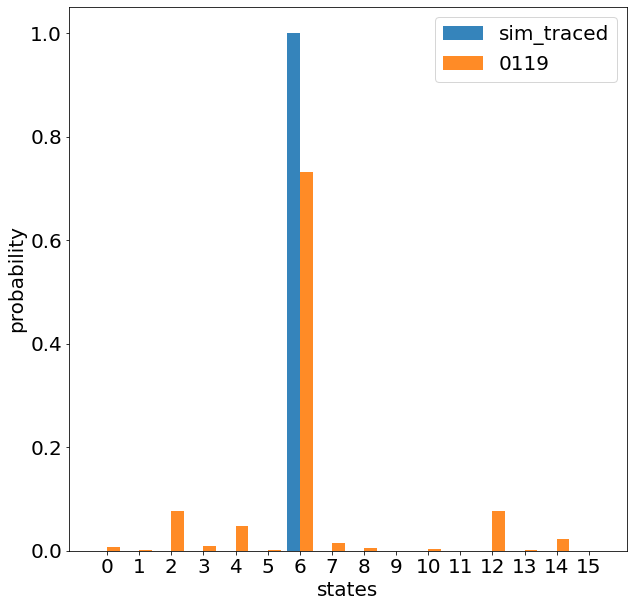

In [33]:
filenames_data=[]
counts_d16=[]
counts_d16_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d16.copy()
print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d16
circuit=c_d16
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d16.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
#     a_0703.Import(paf_data_d16_0115+filenames_d16_0115[i],keep_file=True)
#     data_0703_traced=Trace_Out(a_0703,[0,1,2,3])
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","0119"])

['2024-01-19-171333_Line_001.txt', '2024-01-19-171357_Line_002.txt', '2024-01-19-171420_Line_003.txt', '2024-01-19-171523_Line_004.txt', '2024-01-19-171547_Line_005.txt', '2024-01-19-171611_Line_006.txt', '2024-01-19-171714_Line_007.txt', '2024-01-19-171738_Line_008.txt', '2024-01-19-171802_Line_009.txt', '2024-01-19-171905_Line_010.txt', '2024-01-19-172100_Line_011.txt', '2024-01-19-172123_Line_012.txt', '2024-01-19-172146_Line_013.txt', '2024-01-19-172211_Line_014.txt', '2024-01-19-172313_Line_015.txt', '2024-01-19-172338_Line_016.txt', '2024-01-19-172402_Line_017.txt', '2024-01-19-172425_Line_018.txt', '2024-01-19-172527_Line_019.txt', '2024-01-19-172551_Line_020.txt']
2024-01-19-171333_Line_001.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:AZ2+1.0000:RX+21:AZ2+1.0000:RX+31:RY+31:AZ3+1.0000:RX+21:RY+31:RX+21:RX+31:RY+21:RY+31:RX+21:RX+31:AZ2+1.0000:AZ3+1.0000:RX+21:AZ3+1.0000:RY+21:RX+31:RY+21:RX+21:AZ2+1.0

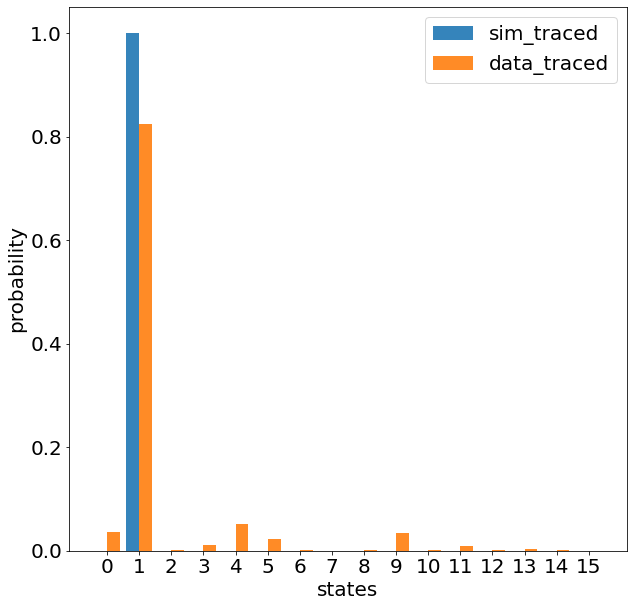

2024-01-19-171357_Line_002.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:RY+21:RY+31:RX+21:AZ3+1.0000:RX+21:RX+31:AZ2+1.0000:RY+21:AZ3+1.0000:RY+21:RX+31:AZ2+1.0000:AZ2+1.0000:RY+31:AZ2+1.0000:RY+21:RY+31:AZ2+1.0000:AZ3+1.0000:RY+21:AZ3+1.0000:RX+21:RY+21:AZ3+1.0000:RY+31:RX+21:RY+31:AZ2+1.0000:RY+31:RY+21:RY+31:RY+21:AZ3+1.0000:AZ2+1.0000:AZ2+1.0000:AZ3+1.0000:RX+21:RY+31:AZ2+1.0000:RY+31:AZ2+1.0000:RX+21:RY+31:RX+21:RX+31:AZ2+1.0000:RX+31:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



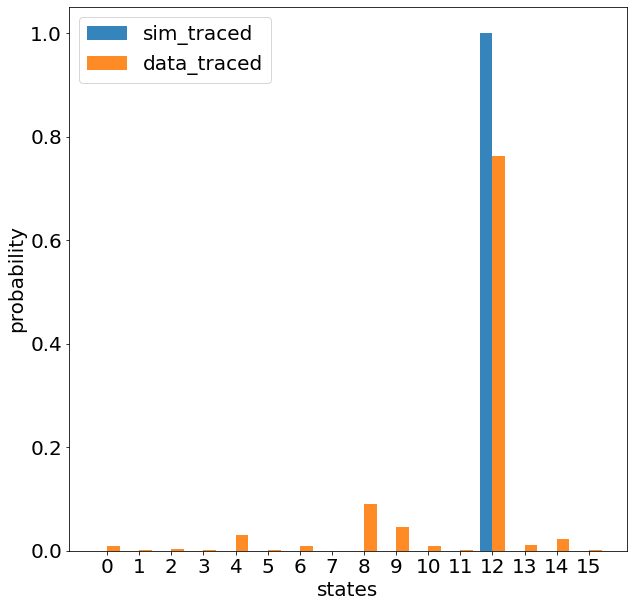

2024-01-19-171420_Line_003.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ2+1.0000:RY+21:RY+31:RY+21:RY+21:AZ3+1.0000:RY+21:AZ3+1.0000:RX+21:RY+31:RX+21:AZ3+1.0000:RX+21:AZ3+1.0000:RX+31:RX+21:RX+31:AZ2+1.0000:RY+31:RX+21:RX+31:AZ3+1.0000:AZ3+1.0000:RX+21:RX+21:RX+21:AZ2+1.0000:RY+31:RY+21:RX+31:AZ3+1.0000:RY+21:AZ3+1.0000:AZ2+1.0000:RX+21:RX+31:RX+21:AZ2+1.0000:RY+31:RX+31:RY+31:RX+21:AZ3+1.0000:RX+21:AZ3+1.0000:RX+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



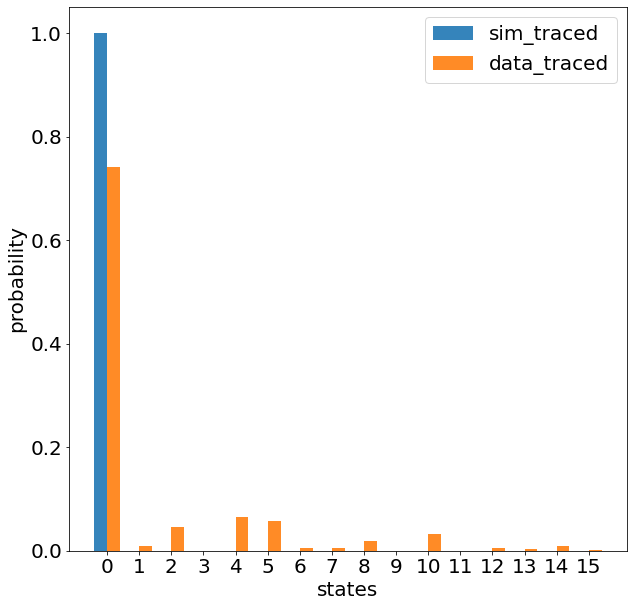

2024-01-19-171523_Line_004.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:AZ2+1.0000:RY+31:RX+31:RX+31:RX+21:AZ3+1.0000:AZ2+1.0000:RX+31:RX+21:RX+31:AZ2+1.0000:RY+31:RY+21:AZ2+1.0000:AZ3+1.0000:RY+21:RX+31:AZ2+1.0000:RY+31:RY+21:AZ3+1.0000:RY+21:AZ3+1.0000:RY+21:RX+31:RY+21:RY+31:RY+31:AZ2+1.0000:RY+21:RX+31:RX+21:AZ3+1.0000:RX+21:AZ2+1.0000:AZ3+1.0000:RX+21:RY+31:RX+21:RY+31:RY+21:RY+31:RX+31:RX+21:AZ3+1.0000:RX+21:AZ3+1.0000:AZ2+1.0000:RY+21:AZ3+1.0000:RX+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



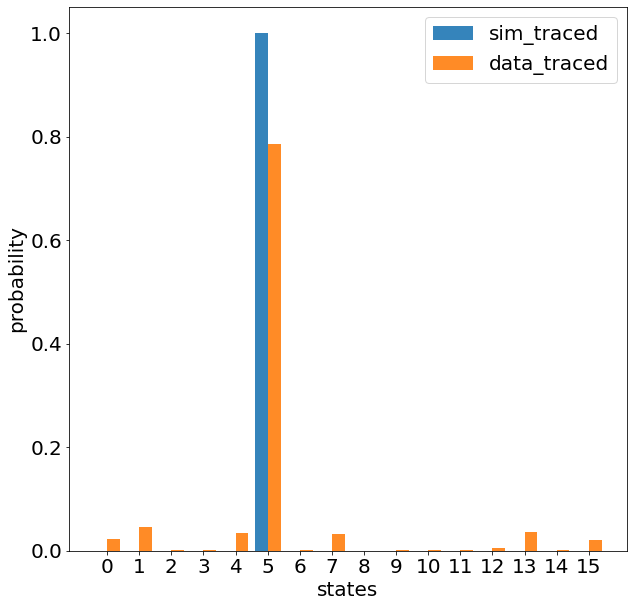

2024-01-19-171547_Line_005.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RY+31:AZ2+1.0000:AZ2+1.0000:RY+21:RX+21:RX+31:RX+21:RX+31:RX+21:AZ2+1.0000:RY+21:RX+31:RX+31:RY+21:AZ3+1.0000:AZ2+1.0000:RX+31:RY+21:RX+31:RY+21:RX+31:RX+21:RX+31:AZ2+1.0000:AZ3+1.0000:RY+21:RX+31:RX+21:AZ3+1.0000:AZ2+1.0000:RY+31:RX+21:RY+31:RX+21:RY+31:RY+21:RY+31:RX+31:RY+31:AZ2+1.0000:RY+31:RY+21:RX+21:RX+21:RY+31:AZ2+1.0000:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



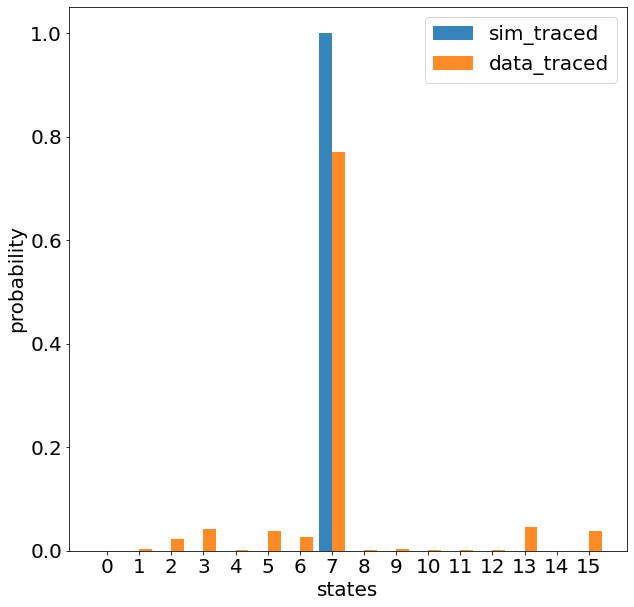

2024-01-19-171611_Line_006.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:RX+21:RX+31:RX+31:RY+21:RX+31:AZ3+1.0000:RX+21:RY+31:RX+21:RY+21:RY+31:RX+21:RX+31:RX+21:RY+31:AZ2+1.0000:RX+21:AZ3+1.0000:AZ3+1.0000:RY+21:RX+31:RX+21:RY+31:RX+21:AZ3+1.0000:RY+21:RX+31:AZ3+1.0000:RY+31:RY+21:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:RX+21:RX+31:AZ2+1.0000:RY+31:RY+31:AZ2+1.0000:RX+31:AZ2+1.0000:AZ3+1.0000:RX+21:RX+31:RX+21:AZ3+1.0000:RX+21:RX+31:RY+21:AZ3+1.0000:RY+31:RX+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



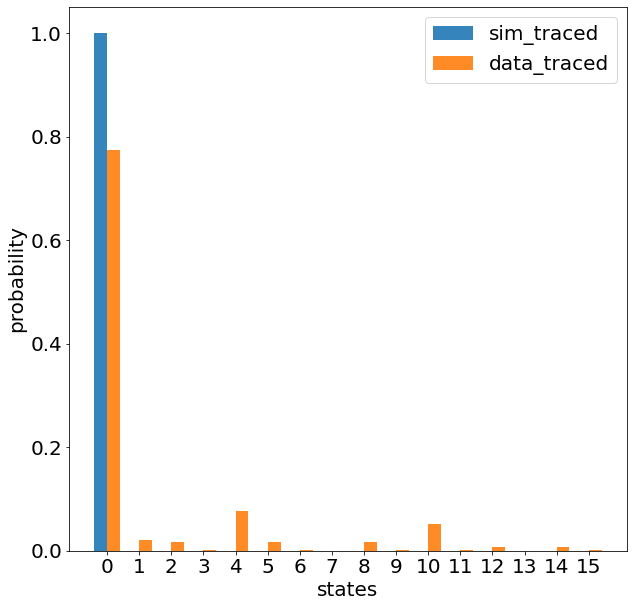

2024-01-19-171714_Line_007.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:RY+21:AZ2+1.0000:AZ3+1.0000:RX+21:RX+31:AZ2+1.0000:AZ3+1.0000:RX+21:RY+31:AZ2+1.0000:RY+31:AZ2+1.0000:RY+31:AZ3+1.0000:RY+21:RY+21:RY+21:RY+31:RY+31:AZ2+1.0000:AZ3+1.0000:RY+31:AZ2+1.0000:RY+31:RX+21:RX+31:RY+21:RX+31:AZ2+1.0000:AZ3+1.0000:RX+21:RX+31:RY+31:RX+21:RX+21:RY+21:RX+31:RY+21:RY+21:AZ2+1.0000:RY+31:AZ2+1.0000:RY+31:RY+21:RY+31:RX+21:RX+31:RX+31:RX+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



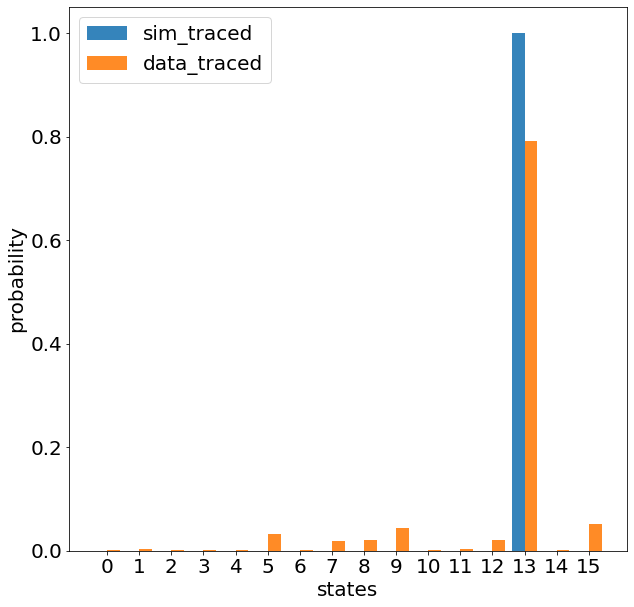

2024-01-19-171738_Line_008.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:RX+21:RX+21:AZ3+1.0000:RX+21:AZ3+1.0000:RX+21:RY+31:RY+21:RY+31:RX+31:RX+21:RY+31:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:AZ3+1.0000:AZ3+1.0000:RY+21:RY+31:AZ2+1.0000:RY+31:AZ2+1.0000:AZ2+1.0000:RY+31:AZ2+1.0000:AZ3+1.0000:RX+21:RY+31:AZ2+1.0000:RX+31:RY+31:RY+31:RY+21:RX+31:RX+21:RY+31:AZ2+1.0000:AZ3+1.0000:RY+21:RY+21:AZ3+1.0000:RY+21:RX+31:RX+21:AZ2+1.0000:AZ3+1.0000:RX+21:AZ3+1.0000:RY+21:RY+31:RY+21:AZ2+1.0000:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



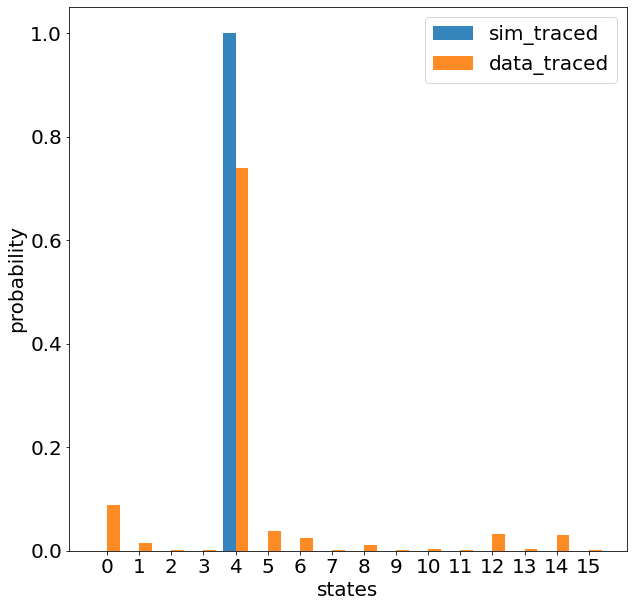

2024-01-19-171802_Line_009.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:RX+31:AZ2+1.0000:RY+31:RY+21:RX+31:RY+21:AZ3+1.0000:RY+21:RY+31:RX+21:RY+21:RX+21:RX+31:RX+21:RX+31:AZ2+1.0000:AZ3+1.0000:RY+21:AZ2+1.0000:RX+31:AZ2+1.0000:AZ2+1.0000:AZ3+1.0000:AZ2+1.0000:RX+31:RY+21:RY+31:RX+21:RY+31:AZ2+1.0000:RX+31:RX+21:AZ3+1.0000:RX+31:RY+21:RX+21:RX+31:AZ2+1.0000:AZ2+1.0000:AZ3+1.0000:RY+21:RY+21:RX+31:AZ3+1.0000:RX+21:RX+31:RX+21:AZ3+1.0000:RY+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



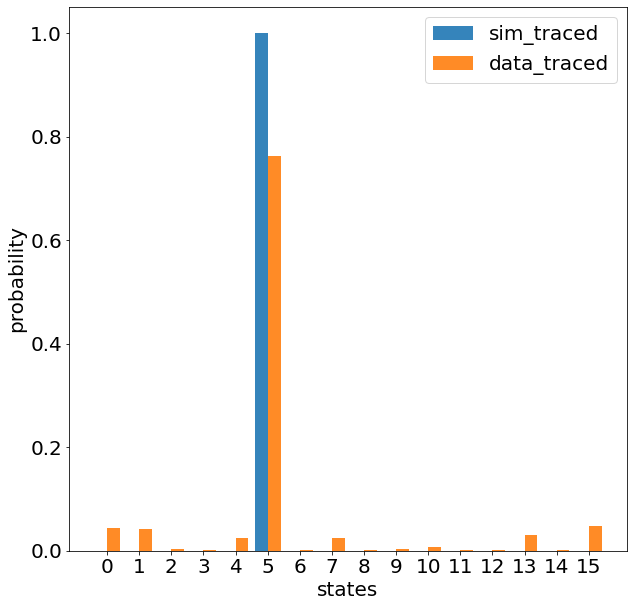

2024-01-19-171905_Line_010.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:RY+31:RX+21:RY+31:AZ2+1.0000:RY+31:AZ2+1.0000:RX+31:RX+21:RX+31:RY+21:RX+31:RX+21:AZ3+1.0000:RX+21:AZ2+1.0000:RX+31:RX+31:RY+21:RX+21:RX+31:AZ2+1.0000:RY+21:RX+31:RX+31:AZ3+1.0000:AZ2+1.0000:RX+31:RY+21:AZ3+1.0000:RY+21:RY+31:RX+21:RY+31:RX+21:AZ3+1.0000:RX+31:RY+31:RX+21:AZ3+1.0000:RX+21:RX+31:AZ2+1.0000:RY+31:AZ2+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



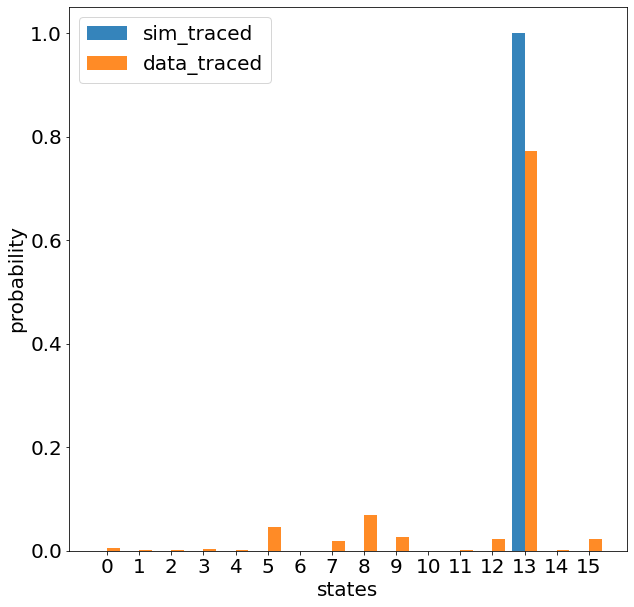

2024-01-19-172100_Line_011.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:AZ3+1.0000:RY+21:RX+31:AZ3+1.0000:AZ3+1.0000:RX+21:RX+31:RY+31:AZ2+1.0000:AZ3+1.0000:RX+21:AZ2+1.0000:RX+31:RY+31:AZ2+1.0000:RY+31:AZ2+1.0000:RX+31:AZ2+1.0000:RX+31:RY+21:RX+21:AZ3+1.0000:RY+21:AZ2+1.0000:RY+31:AZ2+1.0000:RX+21:RY+21:RX+31:RY+21:RY+31:RX+21:AZ3+1.0000:RY+31:AZ2+1.0000:AZ2+1.0000:RX+31:RY+21:RX+31:RY+21:AZ2+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



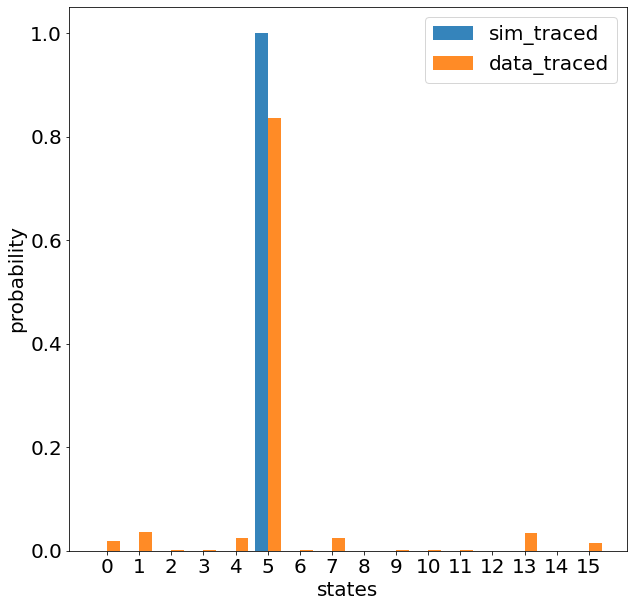

2024-01-19-172123_Line_012.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:AZ2+1.0000:RX+31:RX+31:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:RY+21:RY+21:RX+31:RX+21:RY+31:AZ2+1.0000:RX+21:AZ3+1.0000:AZ2+1.0000:AZ2+1.0000:RY+31:AZ3+1.0000:RY+21:RX+31:RY+21:RY+31:RY+21:RX+31:RY+31:RX+21:AZ3+1.0000:AZ2+1.0000:RY+31:RY+21:AZ3+1.0000:RY+21:RY+31:AZ2+1.0000:RX+31:AZ2+1.0000:RY+31:RY+21:RY+21:RX+31:RY+21:RX+31:RX+21:RY+21:RX+31:AZ3+1.0000:RY+21:RY+31:AZ2+1.0000:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



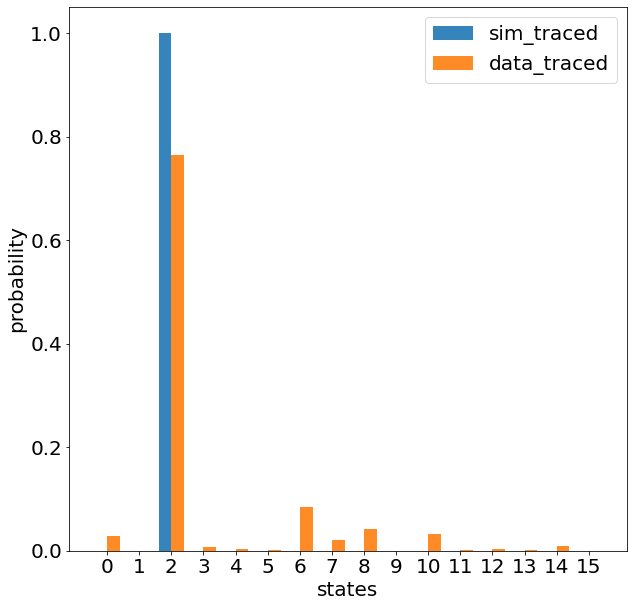

2024-01-19-172146_Line_013.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+31:AZ3+1.0000:AZ2+1.0000:RY+31:RY+21:AZ3+1.0000:RY+21:AZ3+1.0000:RX+21:RX+31:RY+21:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:RX+31:RX+21:RX+31:RX+21:RX+31:RY+21:RY+31:RX+31:AZ2+1.0000:AZ3+1.0000:AZ2+1.0000:RY+31:RX+21:AZ3+1.0000:AZ2+1.0000:RY+31:RY+21:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:RY+31:RX+21:AZ3+1.0000:RX+31:AZ2+1.0000:AZ3+1.0000:RX+21:RX+31:RY+31:RY+21:RY+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



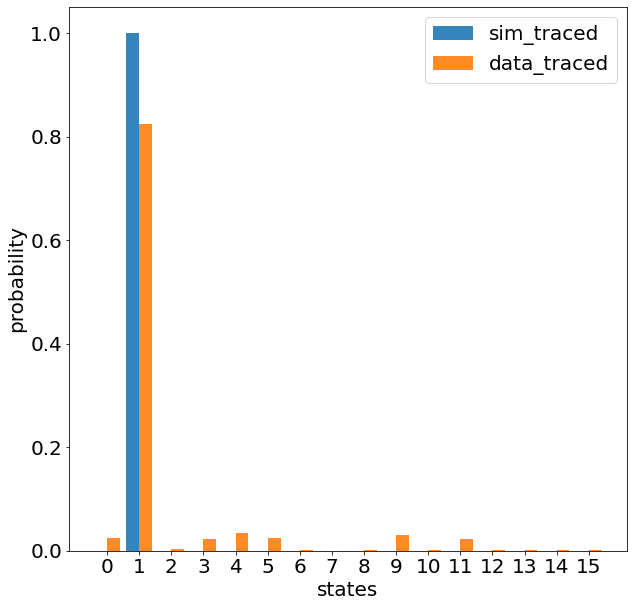

2024-01-19-172211_Line_014.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:RY+21:RY+31:AZ2+1.0000:AZ3+1.0000:RY+21:RY+31:RY+31:RX+21:AZ3+1.0000:RX+31:AZ2+1.0000:AZ3+1.0000:RX+21:RX+31:RY+21:AZ3+1.0000:RY+21:RY+31:AZ2+1.0000:AZ3+1.0000:RX+21:RX+31:RY+21:AZ3+1.0000:RX+21:RY+31:RX+21:RX+31:RY+21:AZ3+1.0000:RY+31:RY+21:RY+31:RY+21:AZ3+1.0000:RX+21:RX+31:RY+21:RY+31:AZ3+1.0000:RY+21:AZ2+1.0000:RX+31:RX+21:AZ3+1.0000:RX+21:RX+31:RY+21:RX+31:RY+21:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



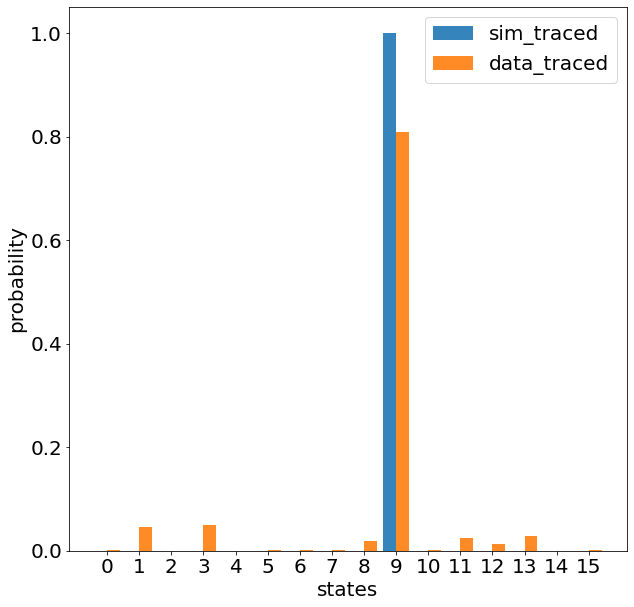

2024-01-19-172313_Line_015.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ3+1.0000:RX+31:AZ2+1.0000:RX+31:RX+31:AZ2+1.0000:AZ3+1.0000:RX+21:RX+31:RX+21:AZ3+1.0000:AZ2+1.0000:RY+31:RX+21:RY+31:RY+21:RX+31:RX+21:RY+31:RX+21:RY+31:RX+21:RY+31:AZ2+1.0000:RY+31:RY+21:AZ2+1.0000:AZ2+1.0000:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:RY+31:RX+21:RX+21:RY+31:RY+21:AZ3+1.0000:AZ2+1.0000:RY+31:AZ2+1.0000:RY+31:RY+21:RX+21:RY+31:AZ2+1.0000:RX+31:AZ2+1.0000:RY+31:RY+21:RX+21:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



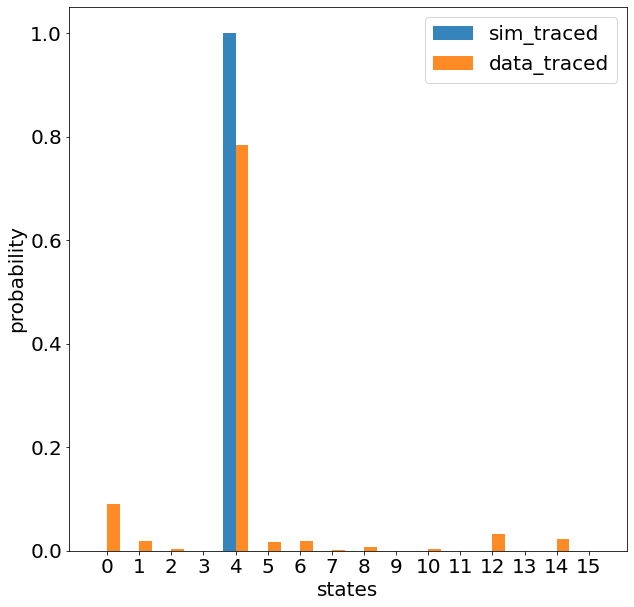

2024-01-19-172338_Line_016.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RX+31:RY+21:RX+31:RX+21:AZ3+1.0000:AZ2+1.0000:RX+31:RX+21:RY+31:RY+21:RY+31:RX+21:AZ3+1.0000:AZ2+1.0000:RX+31:AZ2+1.0000:AZ3+1.0000:RY+21:RY+31:RY+21:RX+31:RX+21:AZ2+1.0000:RY+21:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:RX+21:AZ3+1.0000:RY+31:AZ2+1.0000:RX+31:RY+21:RX+31:RY+21:RY+31:RX+21:RX+31:AZ2+1.0000:RX+31:RX+21:RX+31:RY+21:RY+31:RX+21:RY+31:RX+31:RY+21:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



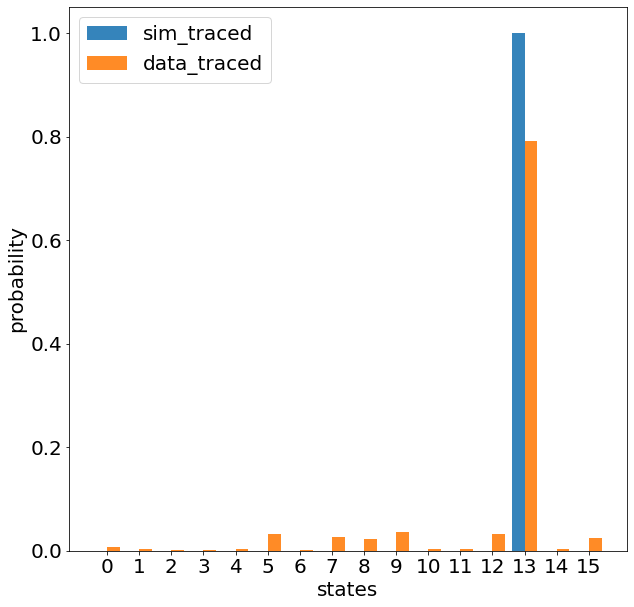

2024-01-19-172402_Line_017.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RY+21:AZ3+1.0000:RY+21:AZ3+1.0000:RY+21:RY+31:RY+21:RX+31:RY+31:RY+21:RX+21:RY+21:AZ3+1.0000:RY+21:RX+31:RX+21:AZ3+1.0000:AZ2+1.0000:RX+21:RY+31:RY+21:AZ3+1.0000:RX+21:AZ3+1.0000:AZ3+1.0000:AZ2+1.0000:RX+21:AZ3+1.0000:RX+21:AZ3+1.0000:RY+21:RY+31:RX+21:RX+21:AZ2+1.0000:RX+21:RX+31:RY+21:RX+31:AZ2+1.0000:RY+31:RX+21:AZ3+1.0000:RY+21:AZ3+1.0000:RX+21:AZ3+1.0000:RY+21:RY+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



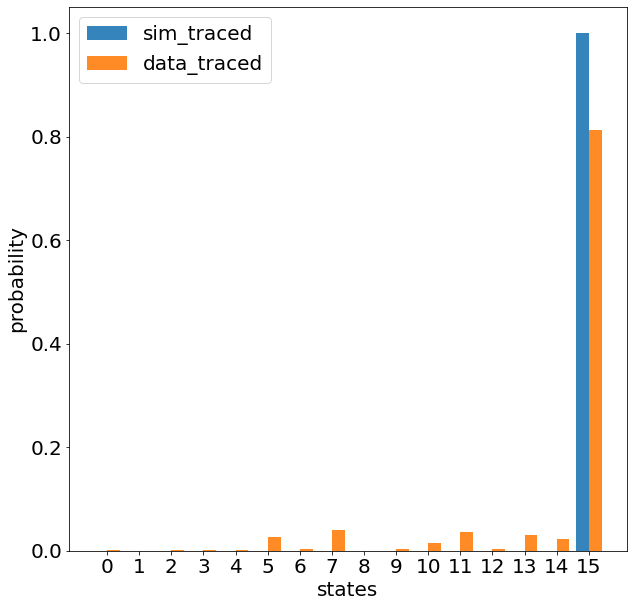

2024-01-19-172425_Line_018.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:RX+31:RX+21:AZ2+1.0000:AZ3+1.0000:AZ3+1.0000:RY+21:AZ3+1.0000:RX+21:RX+21:AZ2+1.0000:RX+31:RX+21:RY+31:AZ3+1.0000:AZ3+1.0000:AZ2+1.0000:AZ3+1.0000:RX+21:RX+21:RY+31:AZ2+1.0000:AZ3+1.0000:RX+21:RX+21:AZ2+1.0000:RX+21:AZ3+1.0000:RY+21:RY+21:RX+21:RX+31:RY+21:RX+31:RY+21:AZ2+1.0000:RY+21:RY+31:AZ2+1.0000:RX+31:AZ2+1.0000:RX+21:AZ3+1.0000:RX+21:RX+31:AZ2+1.0000:AZ3+1.0000:RY+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



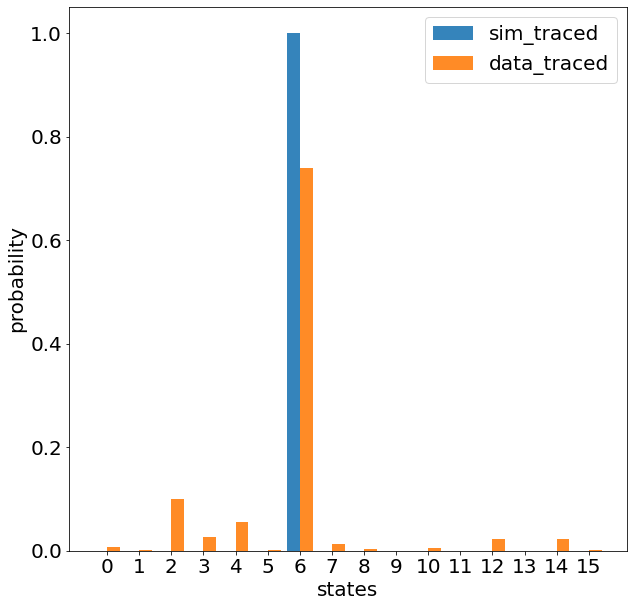

2024-01-19-172527_Line_019.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:AZ2+1.0000:RY+31:RX+21:AZ3+1.0000:AZ2+1.0000:RX+21:RX+21:RX+31:RY+31:AZ2+1.0000:AZ3+1.0000:AZ3+1.0000:AZ2+1.0000:RY+31:RX+21:AZ3+1.0000:RX+31:RY+21:AZ2+1.0000:AZ3+1.0000:RY+21:RY+31:AZ2+1.0000:RX+21:RY+31:RY+21:RX+31:RX+21:AZ3+1.0000:RX+31:RY+21:RY+31:RX+21:AZ3+1.0000:RX+21:RX+31:RY+21:RY+31:AZ2+1.0000:RX+31:RY+21:AZ2+1.0000:AZ2+1.0000:RX+31:RY+21:RY+31:RX+21:AZ2+1.0000:RY+21:RX+31:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



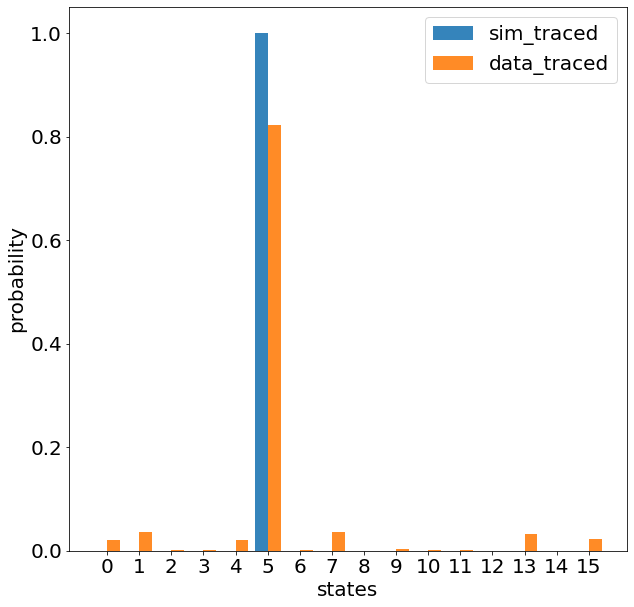

2024-01-19-172551_Line_020.txt
HAD2:RX+51:HAD3:RX+41:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:RX+31:RY+21:RY+31:RY+21:AZ3+1.0000:RY+21:RX+31:RX+21:AZ2+1.0000:RY+21:RY+31:AZ2+1.0000:AZ3+1.0000:RX+21:RY+31:AZ2+1.0000:RX+31:RX+21:RY+31:AZ3+1.0000:RX+21:RY+31:AZ2+1.0000:AZ3+1.0000:RX+31:RX+21:RX+31:RY+21:AZ3+1.0000:AZ2+1.0000:RX+31:RY+21:RY+31:RX+21:RY+21:RY+21:AZ3+1.0000:RY+21:RX+31:RY+31:RY+21:AZ3+1.0000:RY+31:RY+21:RX+31:RX+31:RY+21:RX+31:AZ2+1.0000:AZ2+1.0000:AZ3+1.0000:RY+22:FTXA250.2500+:RY-22:RX-52:AZ2-0.5000:RY+32:FTXA340.2500+:RY-32:RX-42:AZ3-0.5000:HAD2:HAD3



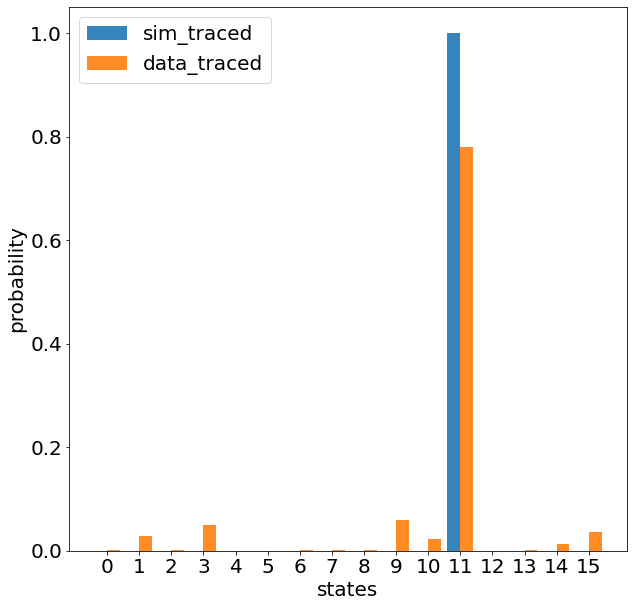

In [35]:
filenames_data=[]
counts_d32=[]
counts_d32_spam=[]
counts=[]
counts_spam=[]
filenames_data=filenames_d32.copy()
print (filenames_data)
# # print (len(filenames_data))
paf_data=paf_data_d32
circuit=c_d32
for i in range (len(filenames_data)):
    print (filenames_data[i])
    a.Import(paf_data+filenames_data[i],keep_file=True)
    data_traced=Trace_Out(a,[0,1,2,3])
    counts=[round(shots*x) for x in  data_traced.population]
    counts_ibm_mapping, counts_ibm_mapping_dic=map_statepop_2_ibm_mapping(counts,nqubit)
    counts_d32.append(counts_ibm_mapping_dic)
    
#     a_s=spam1.Correct_SPAM(a)
#     data_traced_spam=Trace_Out(a_s,[0,1,2,3])
#     counts_spam=[round(shots*x) for x in  data_traced_spam.population]
#     counts_ibm_mapping_spam, counts_ibm_mapping_dic_spam=map_statepop_2_ibm_mapping(counts_spam,nqubit)
#     counts_d8_spam.append(counts_ibm_mapping_dic_spam)
    
    
    b_c.Interpret_GatesLab_Sequence(circuit[i])
    print (circuit[i])
    b=b_c.Simulate()
    sim_traced=Trace_Out(b,[0,1,2,3])
#     Display_States_Population(states=[b,a,a_s],label=["simulation","d=8","spam"])
    Display_States_Population(states=[sim_traced,data_traced],label=["sim_traced","data_traced"])

In [36]:
# print (counts_d2[0])
# print (counts_d2_spam[0])

In [37]:
import copy
from copy import copy, deepcopy
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/circuits/XX23541_noSE_explicitCNOT_FT_R0627_01+10/5842626d-f518-4838-a0a2-c93e640ed4ffXX23541_noSE_explicitCNOT_FT_R0627_01+10", "rb") as fp:   # Unpickling
    eab_load = pickle.load(fp)

eab_load_cpy=deepcopy(eab_load[0:100])
eab_load_cpy_spam=deepcopy(eab_load[0:100])

In [38]:
C=20
for i in range (C):
#     print (i)
    assert eab_load_cpy[i]["L"]==2
    print (eab_load_cpy[i]["counts"])
    print (counts_d2_sim[i])

    print (counts_d2[i].copy())
    print ("\n")
    eab_load_cpy[i]["counts"]=counts_d2[i].copy()


    
for i in range (C):
#     print (i)
    assert eab_load_cpy_spam[i]["L"]==2
    eab_load_cpy_spam[i]["counts"]=counts_d2_spam[i].copy()



# for i in range (C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])

{'0000': 0, '1000': 0, '0100': 0, '1100': 2000, '0010': 0, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 0, '1000': 0, '0100': 0, '1100': 2000, '0010': 0, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 4, '1000': 46, '0100': 48, '1100': 1762, '0010': 1, '1010': 5, '0110': 24, '1110': 45, '0001': 0, '1001': 28, '0101': 1, '1101': 32, '0011': 1, '1011': 2, '0111': 0, '1111': 1}


{'0000': 0, '1000': 0, '0100': 0, '1100': 0, '0010': 2000, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 0, '1000': 0, '0100': 0, '1100': 0, '0010': 2000, '1010': 0, '0110': 0, '1110': 0, '0001': 0, '1001': 0, '0101': 0, '1101': 0, '0011': 0, '1011': 0, '0111': 0, '1111': 0}
{'0000': 165, '1000': 37, '0100': 3, '1100': 0, '0010': 1651, '1010': 30, '0110': 26, '1110'

IndexError: list index out of range

In [39]:
for i in range (C,2*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==4
    eab_load_cpy[i]["counts"]=counts_d4[i-C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i]["counts"])
    
# for i in range (C,2*C):
# #     print (i)
#     assert eab_load_cpy_spam[i]["L"]==4
#     eab_load_cpy_spam[i]["counts"]=counts_d4_spam[i-C].copy()

    #     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy_spam[i]["counts"])

# for i in range (C,2*C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])    

In [40]:
for i in range (2*C,3*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==8
    eab_load_cpy[i]["counts"]=counts_d8[i-2*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

# for i in range (2*C,3*C):
# #     print (i)
#     assert eab_load_cpy_spam[i]["L"]==8
#     eab_load_cpy_spam[i]["counts"]=counts_d8_spam[i-2*C].copy()

#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy_spam[i]["counts"])

# for i in range (2*C,3*C):
#     print (eab_load_cpy[i]["counts"])
#     print (eab_load_cpy_spam[i]["counts"])    

In [41]:
# print (eab_load_cpy)

In [42]:
for i in range (3*C,4*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==16
    eab_load_cpy[i]["counts"]=counts_d16[i-3*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

for i in range (4*C,5*C):
#     print (i)
    assert eab_load_cpy[i]["L"]==32
    eab_load_cpy[i]["counts"]=counts_d32[i-4*C].copy()
#     print ( eab_load_cpy[i]["counts_exp"])
#     print (eab_load_cpy[i])

In [43]:
filename = str(uuid.uuid4())
filename+="23541_FTXX_trueidentity_01192024_01+10_ExperimentalData"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0119 true identity/results/"+filename, "wb") as fp:
    pickle.dump(eab_load_cpy, fp)


Data analysis

plot average fidelity and fit

plot fidelity from each circuit and fit

data analysis with bootstrapping

spam results

In [ ]:

b=[]
c=[1,2]
f=c
c=[1]
print (d)
print (b)
print (c)